# Playground for Classification Slides

- Stephen W. Thomas
- Used for MMA 869, MMAI 869, and GMMA 869
- The Easy version - no hard dependencies or packages (but also, less pretty)

In [1]:
import datetime
print(datetime.datetime.now())

2020-03-05 11:31:14.531067


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.metrics import silhouette_score, silhouette_samples
import sklearn.metrics
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.mixture import GaussianMixture

import itertools
import scipy

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))

The scikit-learn version is 0.21.2.


In [4]:
# Create the 'out' directory to store output images
import os
if not os.path.exists('out'):
    os.makedirs('out')

# Generate Data

For educational purposes, we'll generate a synthetic dataset, rather than using a real one, at first. We'll create a dataset that has two features, both informative, with some overlap, but not much.

Later, we'll graduate to using real-world datasets with more features and less seperation between classes.

In [5]:
from sklearn.datasets import make_classification
import random

# After experiementation, this random state generates a "good looking" dataset
r = 4184

X, y = make_classification(n_samples=500, n_features=2, n_redundant=0, n_informative=2,
                           n_clusters_per_class=1, flip_y=0.09, class_sep = 1.1, random_state=r);

X1 = pd.DataFrame(X, columns=['Age', 'Income'])
y1 = pd.Series(y, name='Bought')
df = pd.concat([X1, y1], axis=1)
df.to_csv('data/marketing.csv', index=False)

In [6]:
type(X)
type(y)
df.head()

numpy.ndarray

numpy.ndarray

Age    Income  Bought
0  0.748126  1.185890       0
1 -1.645760 -2.933332       1
2  0.279829  0.835401       0
3  0.195853  1.249209       0
4 -1.357053 -1.409123       1

In [14]:
X.shape
X[1:10,:]
y.shape
y[1:10]
df.head(15)

(500, 2)

array([[-1.64575979, -2.9333321 ],
       [ 0.27982946,  0.83540131],
       [ 0.19585293,  1.24920912],
       [-1.35705338, -1.4091226 ],
       [-0.49425018, -3.00562239],
       [-1.37872953,  0.4408266 ],
       [ 1.14567439,  0.24986299],
       [ 0.96821192,  0.57301515],
       [ 1.56205843, -0.04601173]])

(500,)

array([1, 0, 0, 1, 1, 0, 1, 0, 0])

Age    Income  Bought
0   0.748126  1.185890       0
1  -1.645760 -2.933332       1
2   0.279829  0.835401       0
3   0.195853  1.249209       0
4  -1.357053 -1.409123       1
5  -0.494250 -3.005622       1
6  -1.378730  0.440827       0
7   1.145674  0.249863       1
8   0.968212  0.573015       0
9   1.562058 -0.046012       0
10  2.336449  2.159094       0
11 -0.601315  1.114726       1
12 -1.739327 -2.246285       1
13  0.955808  0.585645       0
14 -0.668198 -0.615540       1

# Splitting the Data

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df[['Age', 'Income']], df['Bought'], test_size=0.2, random_state=42)

# Helper Functions for Plotting Decision Boundary, etc.

You can ignore the details of this function. It's pretty advanced. It's just used to make the pretty decision boundary plots.

In [8]:
from matplotlib.colors import ListedColormap
from matplotlib.colors import LinearSegmentedColormap
from sklearn.metrics import roc_curve, auc

# Adopted from: https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html


def plot_boundaries(X_train, X_test, y_train, y_test, clf, clf_name, ax, hide_ticks=True, show_train=True, show_test=True):
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    X = np.concatenate((X_train, X_test), axis=0)
    y = np.concatenate((y_train, y_test), axis=0)
    
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02), np.arange(y_min, y_max, 0.02));
    
    
    score = clf.score(X_test, y_test);

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    if hasattr(clf, "decision_function"):
        Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()]);
    else:
        Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1];

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, cmap=cm, alpha=.8);

    if show_train:
        # Plot the training points
        ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=50, cmap=cm_bright, edgecolors='k', alpha=0.6);
        
    if show_test:
        # Plot the testing points
        ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, s=50, cmap=cm_bright, edgecolors='k', alpha=0.6);

    ax.set_xlim(xx.min(), xx.max());
    ax.set_ylim(yy.min(), yy.max());
    if hide_ticks:
        ax.set_xticks(());
        ax.set_yticks(());
    else:
        ax.tick_params(axis='both', which='major', labelsize=18)
        #ax.yticks(fontsize=18);
        
    ax.set_title(clf_name, fontsize=28);
    
    if show_test:
        ax.text(xx.max() - .3, yy.min() + .3, ('%.2f' % score).lstrip('0'), size=35, horizontalalignment='right');
    ax.grid();
    
    

def plot_roc(clf, X_test, y_test, name, ax, show_thresholds=True):
    y_pred_rf = clf.predict_proba(X_test)[:, 1]
    fpr, tpr, thr = roc_curve(y_test, y_pred_rf)

    ax.plot([0, 1], [0, 1], 'k--');
    ax.plot(fpr, tpr, label='{}, AUC={:.2f}'.format(name, auc(fpr, tpr)));
    ax.scatter(fpr, tpr);

    if show_thresholds:
        for i, th in enumerate(thr):
            ax.text(x=fpr[i], y=tpr[i], s="{:.2f}".format(th), fontsize=14, 
                     horizontalalignment='left', verticalalignment='top', color='black',
                     bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.1', alpha=0.1));
        
    ax.set_xlabel('False positive rate', fontsize=18);
    ax.set_ylabel('True positive rate', fontsize=18);
    ax.tick_params(axis='both', which='major', labelsize=18);
    ax.grid(True);
    ax.set_title('ROC Curve', fontsize=18)
    

# Decision Trees

In [9]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(random_state=42, criterion="entropy",
                             min_samples_split=10, min_samples_leaf=10, max_depth=3, max_leaf_nodes=5)
clf.fit(X_train, y_train)

y_pred_dt = clf.predict(X_test)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=3,
                       max_features=None, max_leaf_nodes=5,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=42, splitter='best')

In [10]:
feature_names = X1.columns
class_names = [str(x) for x in clf.classes_]

## Use the Model to Predict Someone New

In [11]:
clf.predict_proba([[2, 2]])
clf.predict([[2, 2]])

array([[0.93922652, 0.06077348]])

array([0])

## Model Parameters

Surpisingly, sci-kit learn does not have a function to print the decision tree in text format. (It does have a way to graphical render the three, which we'll do later.) For now, we'll just print a few stats about the tree.

In [12]:
print(clf.tree_.node_count)
print(clf.tree_.impurity)
print(clf.tree_.children_left)
print(clf.tree_.threshold)

9
[0.99971144 0.40077522 0.45449306 0.99107606 0.33050773 0.22746906
 0.83147439 0.28998605 0.        ]
[ 1  5  3 -1 -1  7 -1 -1 -1]
[-0.05775159 -0.15540861  0.2254563  -2.         -2.         -0.7764757
 -2.         -2.         -2.        ]


## Model Performance

In [13]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, y_pred_dt)

array([[50,  5],
       [ 5, 40]], dtype=int64)

In [14]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred_dt, target_names=class_names))

              precision    recall  f1-score   support

           0       0.91      0.91      0.91        55
           1       0.89      0.89      0.89        45

    accuracy                           0.90       100
   macro avg       0.90      0.90      0.90       100
weighted avg       0.90      0.90      0.90       100



In [15]:
from sklearn.metrics import accuracy_score, cohen_kappa_score, f1_score, log_loss

print("Accuracy = {:.2f}".format(accuracy_score(y_test, y_pred_dt)))
print("Kappa = {:.2f}".format(cohen_kappa_score(y_test, y_pred_dt)))
print("F1 Score = {:.2f}".format(f1_score(y_test, y_pred_dt)))
print("Log Loss = {:.2f}".format(log_loss(y_test, y_pred_dt)))

Accuracy = 0.90
Kappa = 0.80
F1 Score = 0.89
Log Loss = 3.45


## ROC Curve

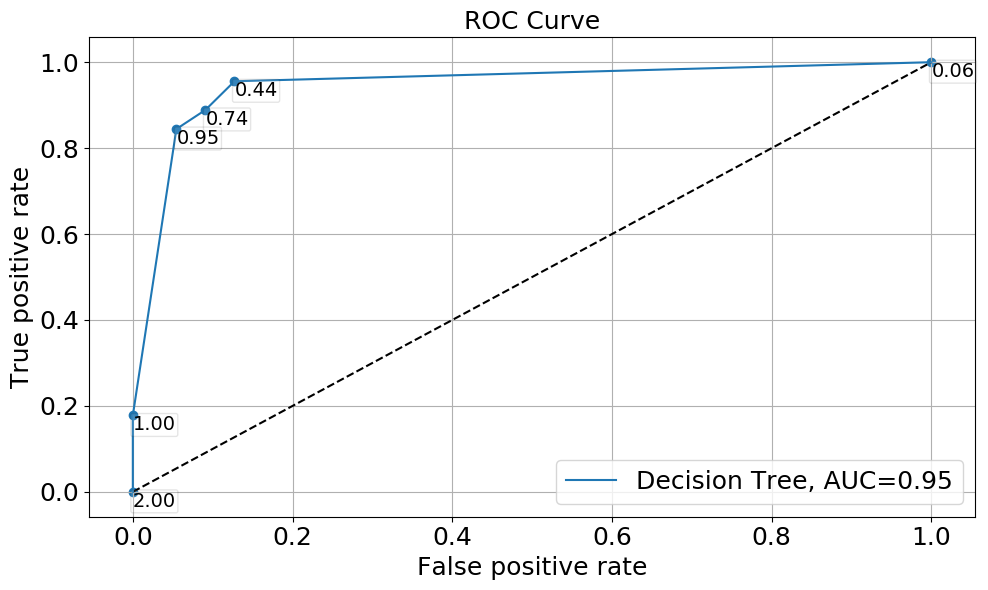

In [16]:
plt.style.use('default');
figure = plt.figure(figsize=(10, 6));    
ax = plt.subplot(1, 1, 1);
plot_roc(clf, X_test, y_test, "Decision Tree", ax)
plt.legend(loc='lower right', fontsize=18);
plt.tight_layout();

## Model Visualization

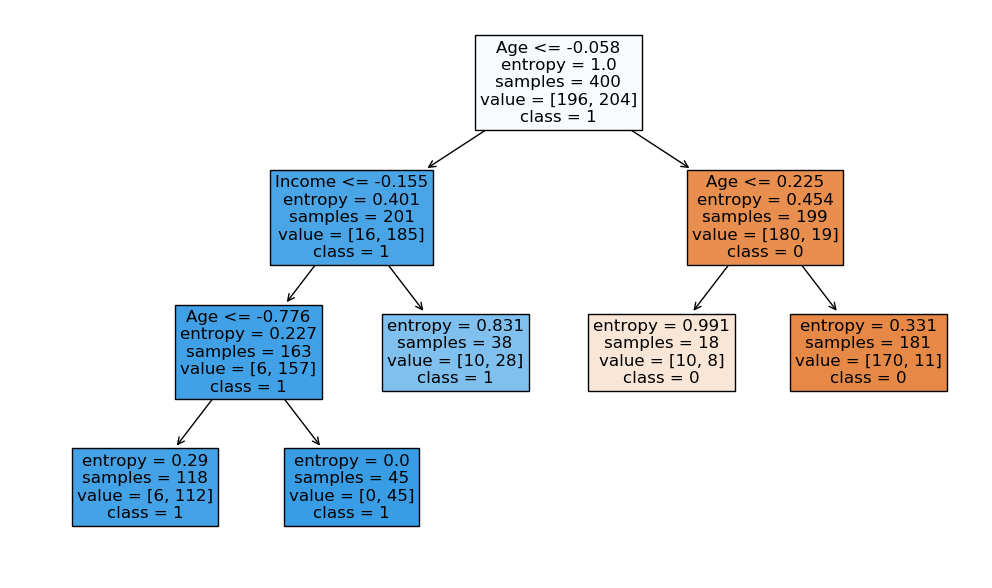

In [17]:
# Needs sklearn 0.21 or higher
from sklearn.tree import plot_tree

plt.figure(figsize=(12, 7));
plot_tree(clf, filled=True, feature_names=feature_names, class_names=class_names, proportion=False, fontsize=12);
plt.savefig('out/marketing-dt-tree.png', transparent=False);

### Decision Boundary

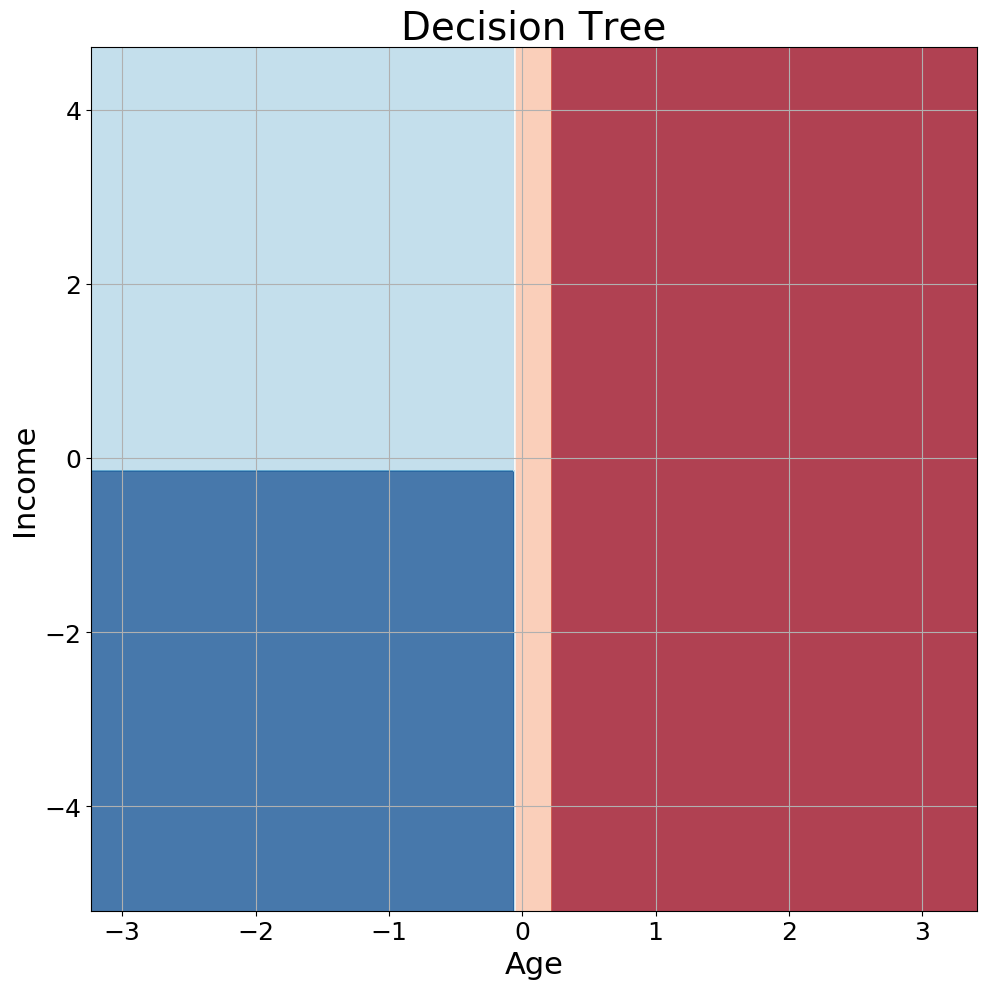

In [123]:
figure = plt.figure(figsize=(10, 10));
ax = plt.subplot(1, 1, 1);
plot_boundaries(X_train, X_test, y_train, y_test, clf, "Decision Tree", ax, hide_ticks=False, show_train=False, show_test=False)
ax.set_xlabel("Age", fontsize=22)
ax.set_ylabel("Income", fontsize=22)
plt.tight_layout();
plt.savefig('out/marketing-dt-decision.png', transparent=False);

TypeError: '(slice(None, None, None), 0)' is an invalid key

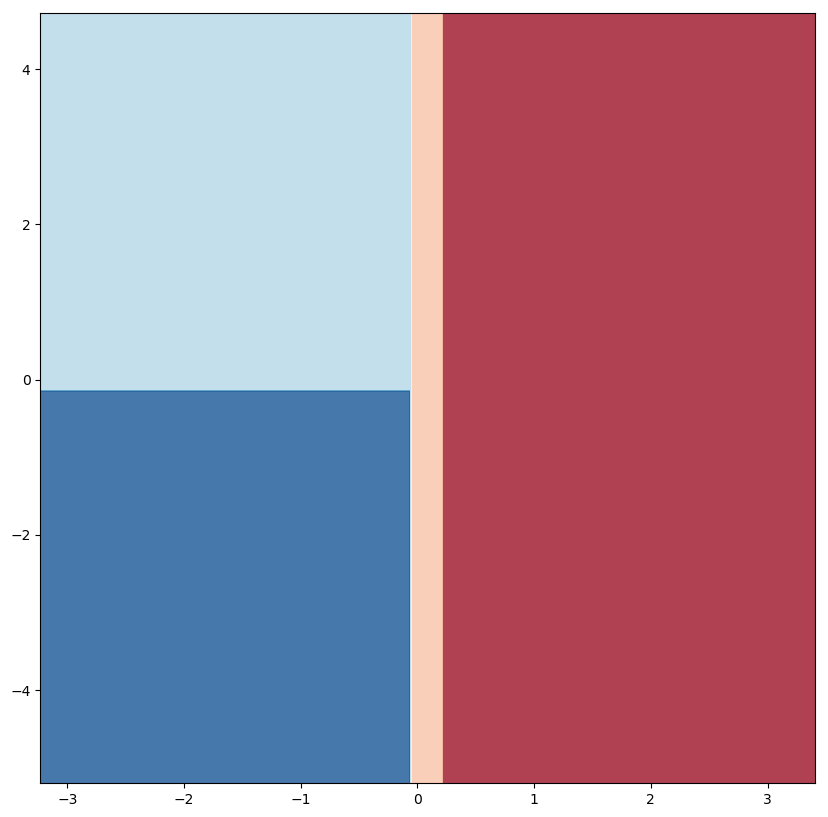

In [19]:
figure = plt.figure(figsize=(10, 10));
ax = plt.subplot(1, 1, 1);
plot_boundaries(X_train, X_test, y_train, y_test, clf, "Decision Tree", ax, hide_ticks=False, show_train=True, show_test=False)
ax.set_xlabel("Age", fontsize=22)
ax.set_ylabel("Income", fontsize=22)
plt.tight_layout();
plt.savefig('out/marketing-dt-decision-train.png', transparent=False);

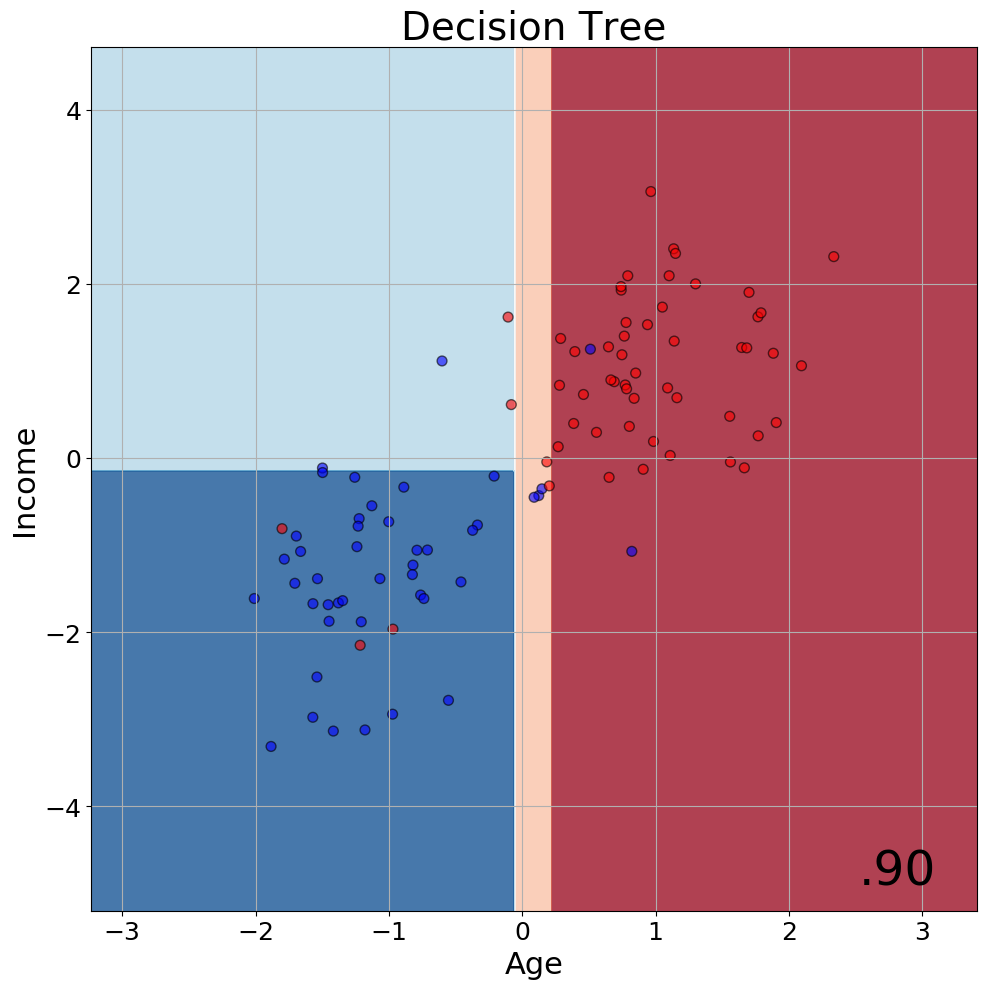

In [125]:
figure = plt.figure(figsize=(10, 10));
ax = plt.subplot(1, 1, 1);
plot_boundaries(X_train, X_test, y_train, y_test, clf, "Decision Tree", ax, hide_ticks=False, show_train=False, show_test=True)
ax.set_xlabel("Age", fontsize=22)
ax.set_ylabel("Income", fontsize=22)
plt.tight_layout();
plt.savefig('out/marketing-dt-decision-test.png', transparent=False);

## Model Selection

### Grid Search

In [71]:
from sklearn.model_selection import GridSearchCV

parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}

treeclf = DecisionTreeClassifier(splitter='best', presort=True, class_weight=None, random_state=42)
parameters = {'criterion':('gini', 'entropy'), 'max_depth':[2, 4, 6, 8, 10], 'min_samples_split':[2, 10, 50], 'min_samples_leaf':[1, 5, 10],
             'max_features':[None, 'auto'], 'max_leaf_nodes':[None, 5, 10, 50], 'min_impurity_decrease':[0, 0.1, 0.2]}
cv_clf = GridSearchCV(treeclf, parameters, scoring='roc_auc', cv=5, return_train_score=True)
%time cv_clf.fit(X, y)

Wall time: 40.9 s


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=True, random_state=42,
                                              splitter='best'),
             iid='warn', n_jobs=None,
             param_grid={'criterion': ('gini', 'entropy'),
                         'max_depth': [2, 4, 6, 8, 10],
                        

In [20]:
cv_clf.best_params_
cv_clf.best_score_
cv_clf.best_estimator_

{'criterion': 'gini',
 'max_depth': 10,
 'max_features': 'auto',
 'max_leaf_nodes': 50,
 'min_impurity_decrease': 0,
 'min_samples_leaf': 5,
 'min_samples_split': 2}

0.9393482753101241

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
                       max_features='auto', max_leaf_nodes=50,
                       min_impurity_decrease=0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=True,
                       random_state=42, splitter='best')

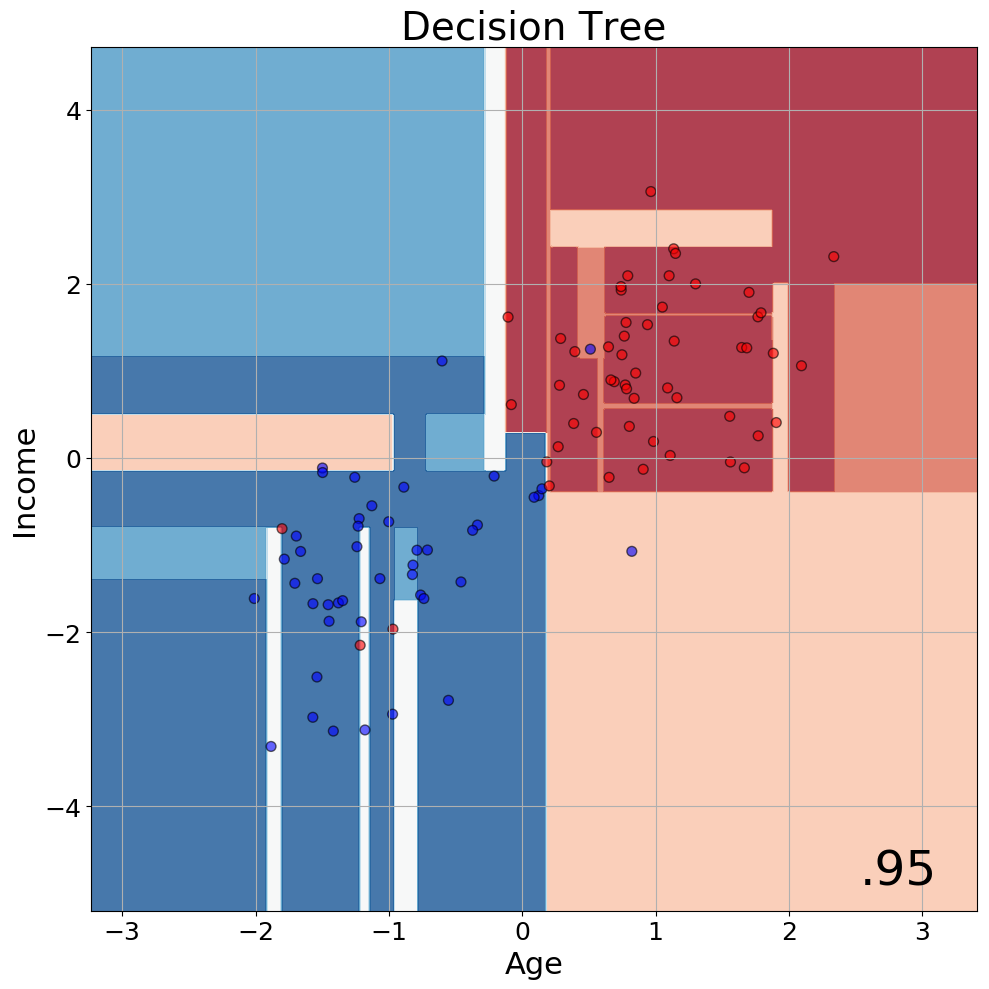

In [126]:
figure = plt.figure(figsize=(10, 10));
ax = plt.subplot(1, 1, 1);
plot_boundaries(X_train, X_test, y_train, y_test, cv_clf.best_estimator_, "Decision Tree", ax, hide_ticks=False, show_train=False)
ax.set_xlabel("Age", fontsize=22)
ax.set_ylabel("Income", fontsize=22)
plt.tight_layout();
plt.savefig('out/marketing-dt-decision-grid-test.png', transparent=False);

# Naive Bayes

In [127]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb = gnb.fit(X_train, y_train)
gnb

y_pred_gnb = gnb.predict(X_test)

GaussianNB(priors=None, var_smoothing=1e-09)

## Model Parameters

In [23]:
gnb.theta_ # Mean of each feature per class
gnb.sigma_ # Variance of each feature per class

array([[ 0.99887777,  1.06512859],
       [-0.91827636, -1.08561939]])

array([[0.70142311, 0.949339  ],
       [0.62737657, 1.68858577]])

## Model Performance

In [24]:
confusion_matrix(y_test, y_pred_gnb)

array([[51,  4],
       [ 2, 43]], dtype=int64)

In [25]:
print(classification_report(y_test, y_pred_gnb, target_names=class_names))

              precision    recall  f1-score   support

           0       0.96      0.93      0.94        55
           1       0.91      0.96      0.93        45

    accuracy                           0.94       100
   macro avg       0.94      0.94      0.94       100
weighted avg       0.94      0.94      0.94       100



In [26]:
print("Accuracy = {:.2f}".format(accuracy_score(y_test, y_pred_gnb)))
print("Kappa = {:.2f}".format(cohen_kappa_score(y_test, y_pred_gnb)))
print("F1 Score = {:.2f}".format(f1_score(y_test, y_pred_gnb)))
print("Log Loss = {:.2f}".format(log_loss(y_test, y_pred_gnb)))

Accuracy = 0.94
Kappa = 0.88
F1 Score = 0.93
Log Loss = 2.07


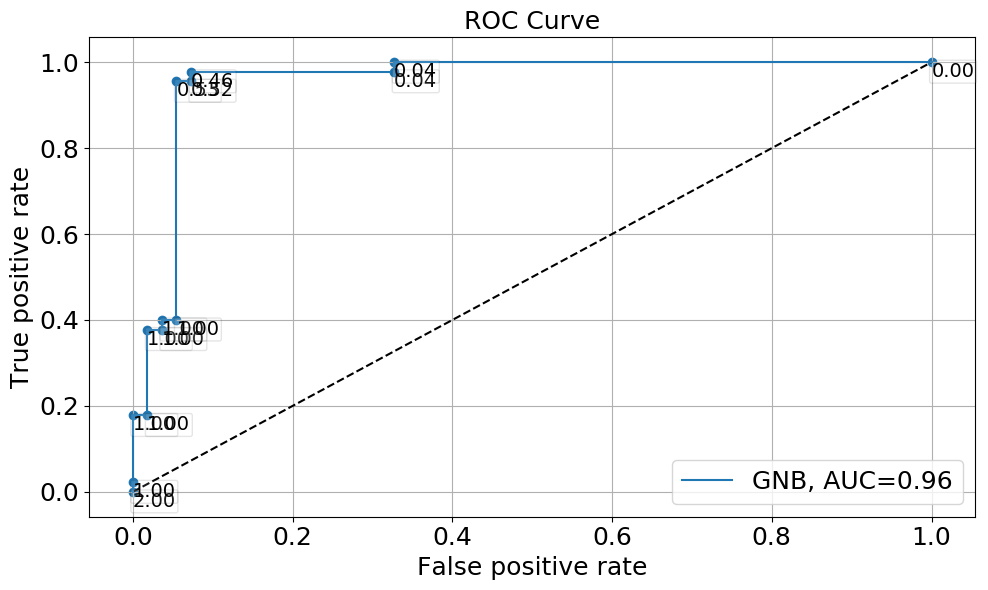

In [27]:
plt.style.use('default');
figure = plt.figure(figsize=(10, 6));    
ax = plt.subplot(1, 1, 1);
plot_roc(gnb, X_test, y_test, "GNB", ax)
plt.legend(loc='lower right', fontsize=18);
plt.tight_layout();

## Model Visualization

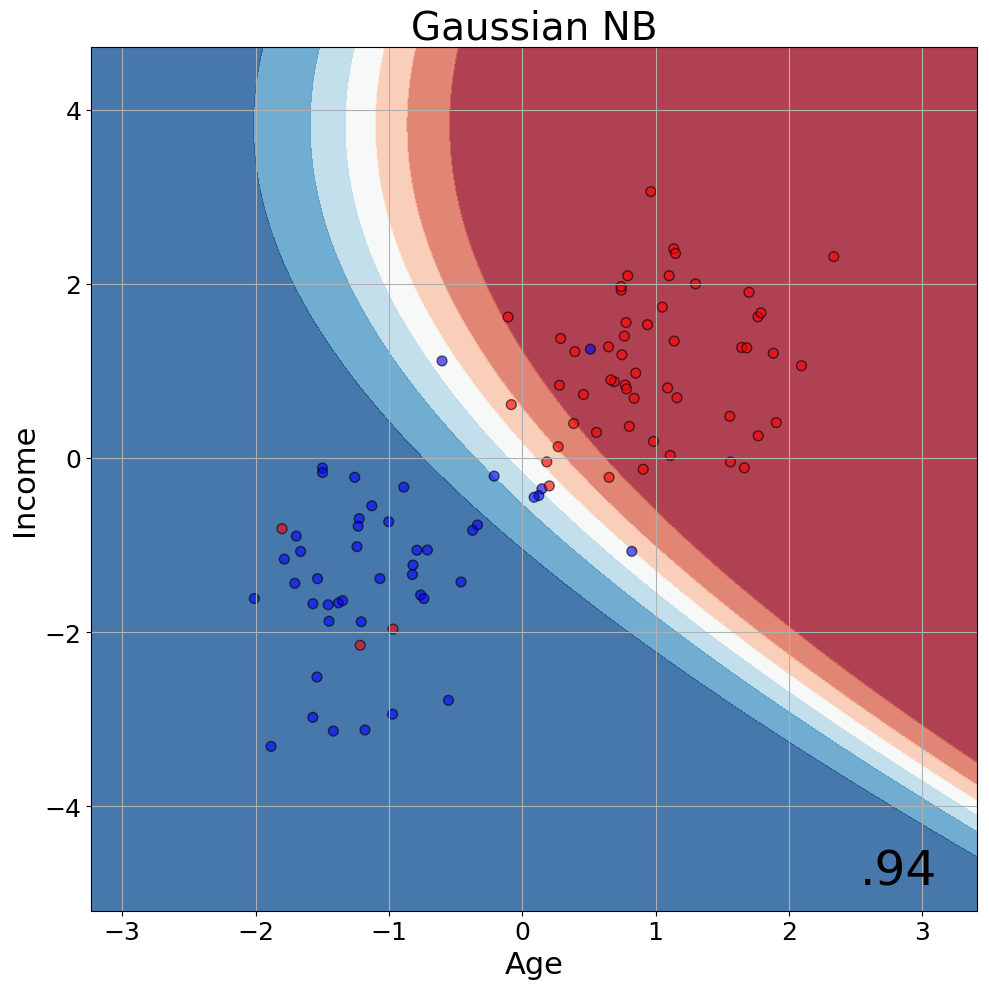

In [128]:
figure = plt.figure(figsize=(10, 10));
ax = plt.subplot(1, 1, 1);
plot_boundaries(X_train, X_test, y_train, y_test, gnb, "Gaussian NB", ax, hide_ticks=False, show_train=False)
ax.set_xlabel("Age", fontsize=22)
ax.set_ylabel("Income", fontsize=22)
plt.tight_layout();
plt.savefig('out/marketing-nb-decision-test.png', transparent=False);

# KNN

In [129]:
from sklearn.neighbors import KNeighborsClassifier

knn_clf = KNeighborsClassifier(n_neighbors=3)
knn_clf.fit(X_train, y_train)

y_pred_knn = knn_clf.predict(X_test)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

## Model Parameters

In [30]:
knn_clf.effective_metric_
knn_clf.effective_metric_params_

'euclidean'

{}

## Model Performance

In [31]:
print(confusion_matrix(y_test, y_pred_knn))

[[47  8]
 [ 2 43]]


In [32]:
print(classification_report(y_test, y_pred_knn, target_names=class_names))

              precision    recall  f1-score   support

           0       0.96      0.85      0.90        55
           1       0.84      0.96      0.90        45

    accuracy                           0.90       100
   macro avg       0.90      0.91      0.90       100
weighted avg       0.91      0.90      0.90       100



In [33]:
print("Accuracy = {:.2f}".format(accuracy_score(y_test, y_pred_knn)))
print("Kappa = {:.2f}".format(cohen_kappa_score(y_test, y_pred_knn)))
print("F1 Score = {:.2f}".format(f1_score(y_test, y_pred_knn)))
print("Log Loss = {:.2f}".format(log_loss(y_test, y_pred_knn)))

Accuracy = 0.90
Kappa = 0.80
F1 Score = 0.90
Log Loss = 3.45


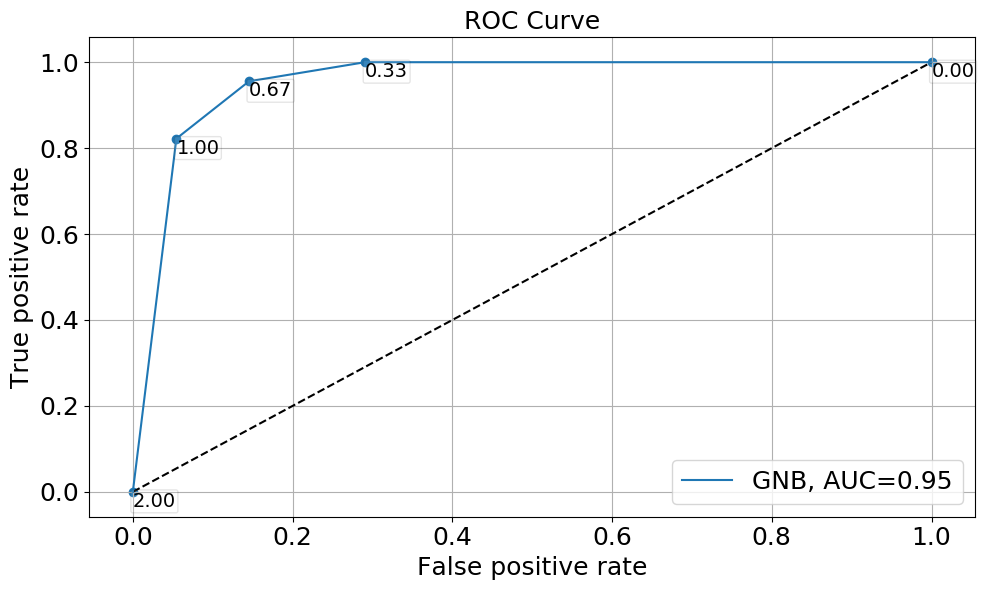

In [34]:
plt.style.use('default');
figure = plt.figure(figsize=(10, 6));    
ax = plt.subplot(1, 1, 1);
plot_roc(knn_clf, X_test, y_test, "GNB", ax)
plt.legend(loc='lower right', fontsize=18);
plt.tight_layout();

## Model Visualization

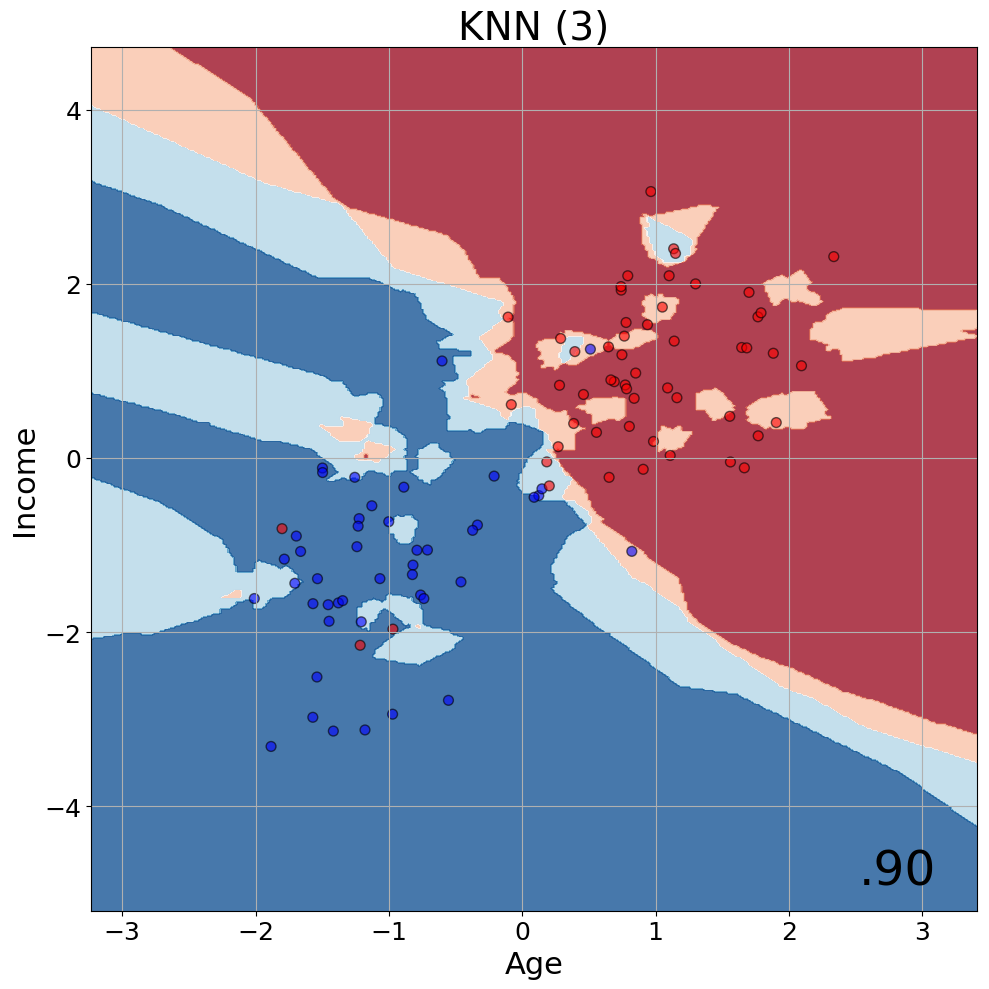

In [130]:
figure = plt.figure(figsize=(10, 10));
ax = plt.subplot(1, 1, 1);
plot_boundaries(X_train, X_test, y_train, y_test, knn_clf, "KNN (3)", ax, hide_ticks=False, show_train=False)
ax.set_xlabel("Age", fontsize=22)
ax.set_ylabel("Income", fontsize=22)
plt.tight_layout();
plt.savefig('out/marketing-knn-decision-test.png', transparent=False);

## Experimenting with Lots of Ks

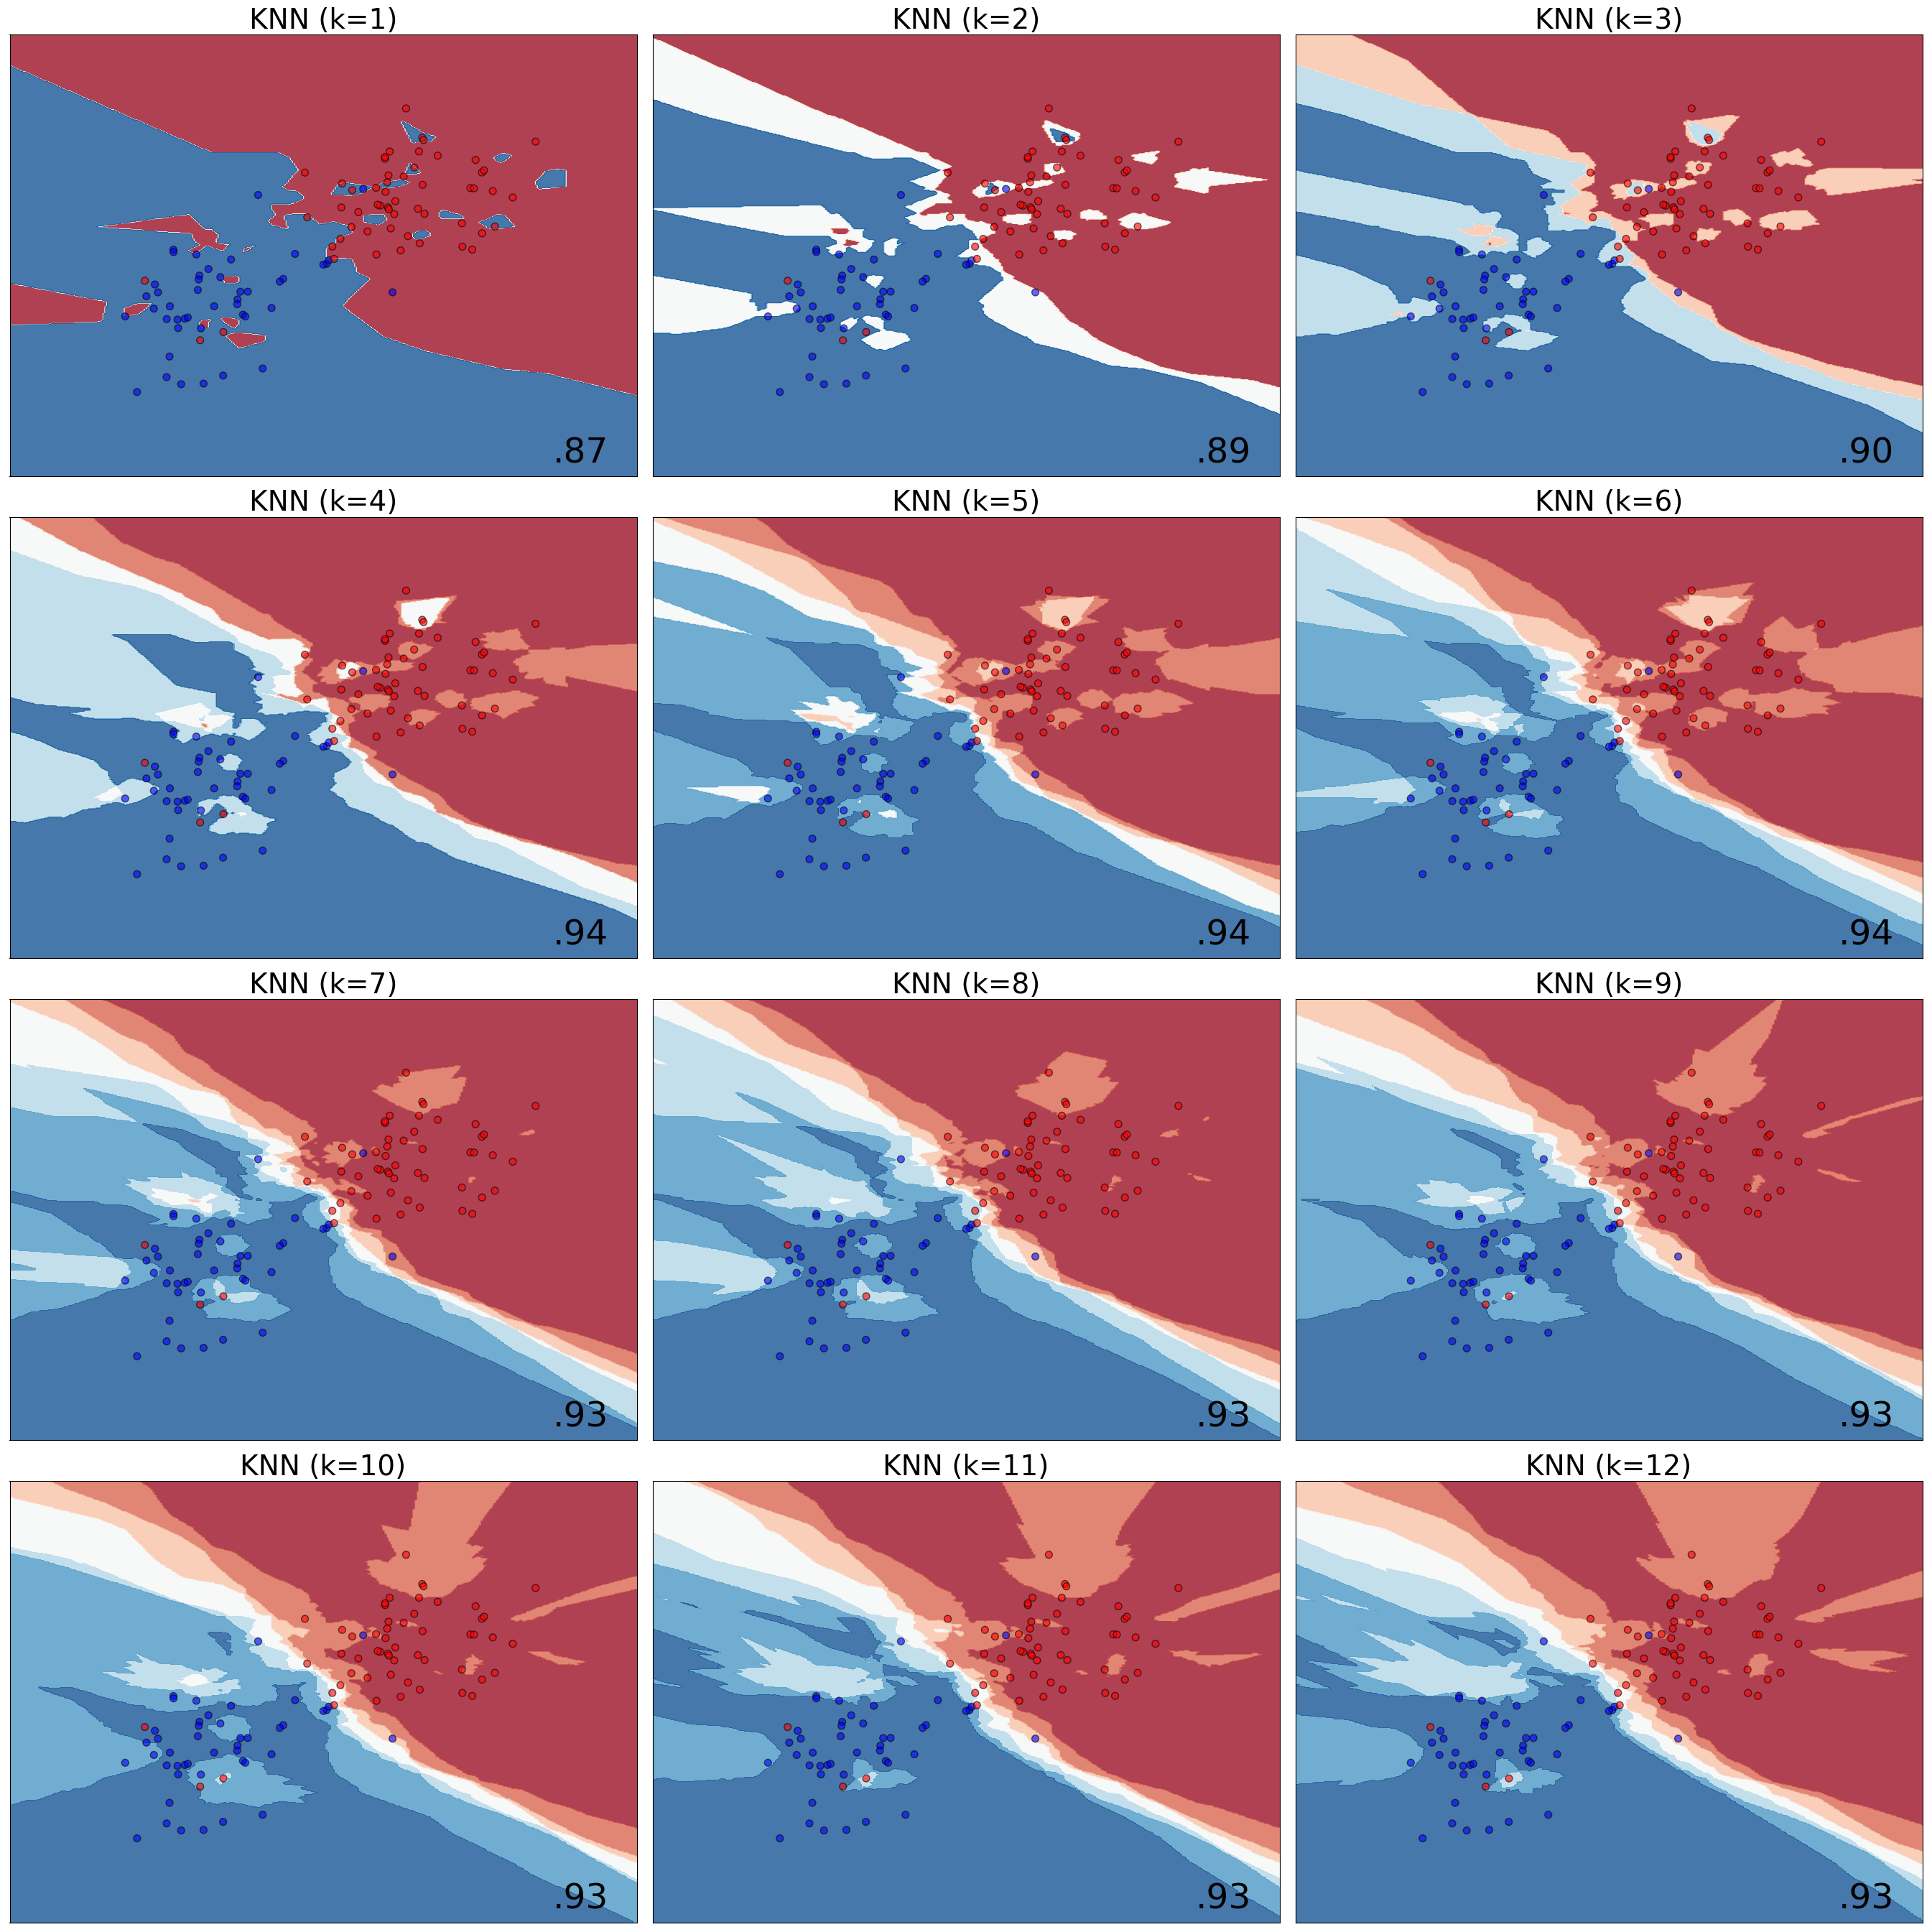

In [104]:
rng = np.random.RandomState(2)

figure = plt.figure(figsize=(27, 27));
i = 1

ks = np.arange(1, 13)

for k in ks:
    ax = plt.subplot(4, 3, i);
    clf_tmp = KNeighborsClassifier(n_neighbors=k)
    clf_tmp.fit(X_train, y_train);
    plot_boundaries(X_train, X_test, y_train, y_test, clf_tmp, "KNN (k={:d})".format(k), ax, hide_ticks=True, show_train=False);
    i += 1

plt.tight_layout();
plt.savefig('out/marketing-knn-decision-test-all.png', transparent=False);

# SVM - Linear

In [132]:
from sklearn.svm import SVC

svm_clf = SVC(kernel="linear", C=0.025)
svm_clf.fit(X_train, y_train)

y_pred_svm = svm_clf.predict(X_test)

SVC(C=0.025, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

## Model Parameters

In [133]:
svm_clf.n_support_

array([70, 69])

In [134]:
svm_clf.support_vectors_

array([[-2.30188062e+00, -1.37169280e+00],
       [-1.18486685e+00, -1.79040549e+00],
       [ 6.59102878e-01, -4.92594995e-02],
       [ 1.88977492e-01,  1.49340633e+00],
       [ 6.32255404e-02,  1.15016778e+00],
       [ 1.23912826e+00, -4.01893060e-01],
       [ 7.49980152e-01, -3.38768128e-01],
       [ 1.23622216e+00,  1.18585351e-01],
       [ 7.19460491e-01,  9.02795935e-01],
       [ 1.95852933e-01,  1.24920912e+00],
       [ 6.24289241e-01,  7.92790019e-01],
       [ 6.76905028e-01, -3.75127816e-01],
       [ 9.03792039e-01,  3.30215452e-01],
       [ 1.27385324e+00, -1.12810817e-02],
       [-8.82249296e-01, -1.76640750e+00],
       [-2.19281611e-02,  1.37013900e+00],
       [ 6.18149343e-01,  8.72452885e-01],
       [ 7.33559474e-01,  3.18524739e-01],
       [ 5.64698788e-01,  8.86571007e-01],
       [-1.13932834e+00,  1.30141500e-01],
       [ 8.88865699e-01,  2.62250487e-01],
       [-1.37872953e+00,  4.40826598e-01],
       [ 8.41265426e-01,  4.54384311e-01],
       [ 1.

In [40]:
svm_clf.dual_coef_ 

array([[-0.025     , -0.025     , -0.025     , -0.025     , -0.025     ,
        -0.025     , -0.025     , -0.025     , -0.025     , -0.025     ,
        -0.025     , -0.025     , -0.025     , -0.025     , -0.025     ,
        -0.025     , -0.025     , -0.025     , -0.025     , -0.025     ,
        -0.025     , -0.025     , -0.025     , -0.00055246, -0.025     ,
        -0.025     , -0.025     , -0.025     , -0.025     , -0.025     ,
        -0.025     , -0.025     , -0.025     , -0.025     , -0.025     ,
        -0.025     , -0.025     , -0.025     , -0.025     , -0.025     ,
        -0.025     , -0.025     , -0.025     , -0.025     , -0.025     ,
        -0.025     , -0.025     , -0.025     , -0.025     , -0.025     ,
        -0.025     , -0.025     , -0.025     , -0.025     , -0.025     ,
        -0.025     , -0.025     , -0.025     , -0.025     , -0.025     ,
        -0.025     , -0.025     , -0.025     , -0.01900603, -0.025     ,
        -0.025     , -0.025     , -0.025     , -0.0

In [41]:
svm_clf.intercept_ 

array([0.0853027])

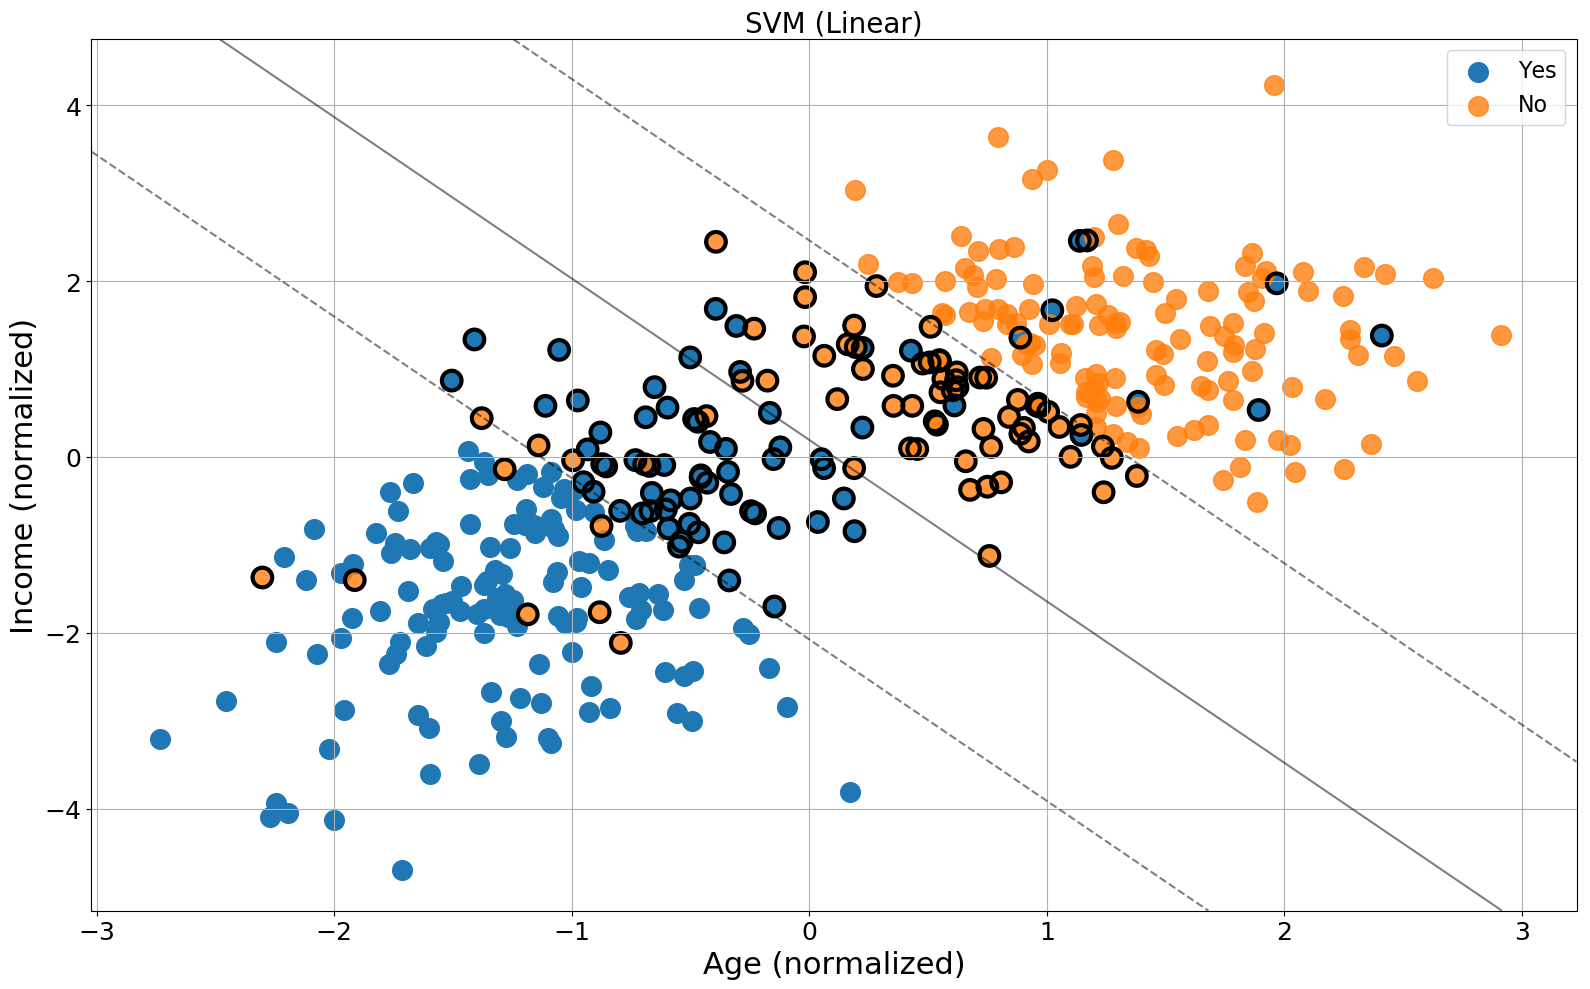

In [135]:
plt.figure(figsize=(16, 10));
plt.grid(True);

ind_d = y_train==1
ind_p = y_train==0
plt.scatter(X_train[ind_d,0], X_train[ind_d,1], marker='o', s=200, label='Yes');
plt.scatter(X_train[ind_p,0], X_train[ind_p,1], marker='o', s=200, label="No", alpha=0.8);

# plot the decision function
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# create grid to evaluate model
xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = svm_clf.decision_function(xy).reshape(XX.shape)

# plot decision boundary and margins
ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])

# plot support vectors
plt.scatter(svm_clf.support_vectors_[:, 0], svm_clf.support_vectors_[:, 1], s=200, linewidth=3, facecolors='none', edgecolors='k')

plt.legend(fontsize=16);
plt.title("SVM (Linear)", fontsize=20);
plt.xlabel('Age (normalized)', fontsize=22);
plt.ylabel('Income (normalized)', fontsize=22);
plt.xticks(fontsize=18);
plt.yticks(fontsize=18);
plt.tight_layout();

## Model Performance

In [43]:
print(confusion_matrix(y_test, y_pred_svm))

[[51  4]
 [ 2 43]]


In [44]:
print(classification_report(y_test, y_pred_svm, target_names=class_names))

              precision    recall  f1-score   support

           0       0.96      0.93      0.94        55
           1       0.91      0.96      0.93        45

    accuracy                           0.94       100
   macro avg       0.94      0.94      0.94       100
weighted avg       0.94      0.94      0.94       100



In [45]:
print("Accuracy = {:.2f}".format(accuracy_score(y_test, y_pred_svm)))
print("Kappa = {:.2f}".format(cohen_kappa_score(y_test, y_pred_svm)))
print("F1 Score = {:.2f}".format(f1_score(y_test, y_pred_svm)))
print("Log Loss = {:.2f}".format(log_loss(y_test, y_pred_svm)))

Accuracy = 0.94
Kappa = 0.88
F1 Score = 0.93
Log Loss = 2.07


## Model Visualization

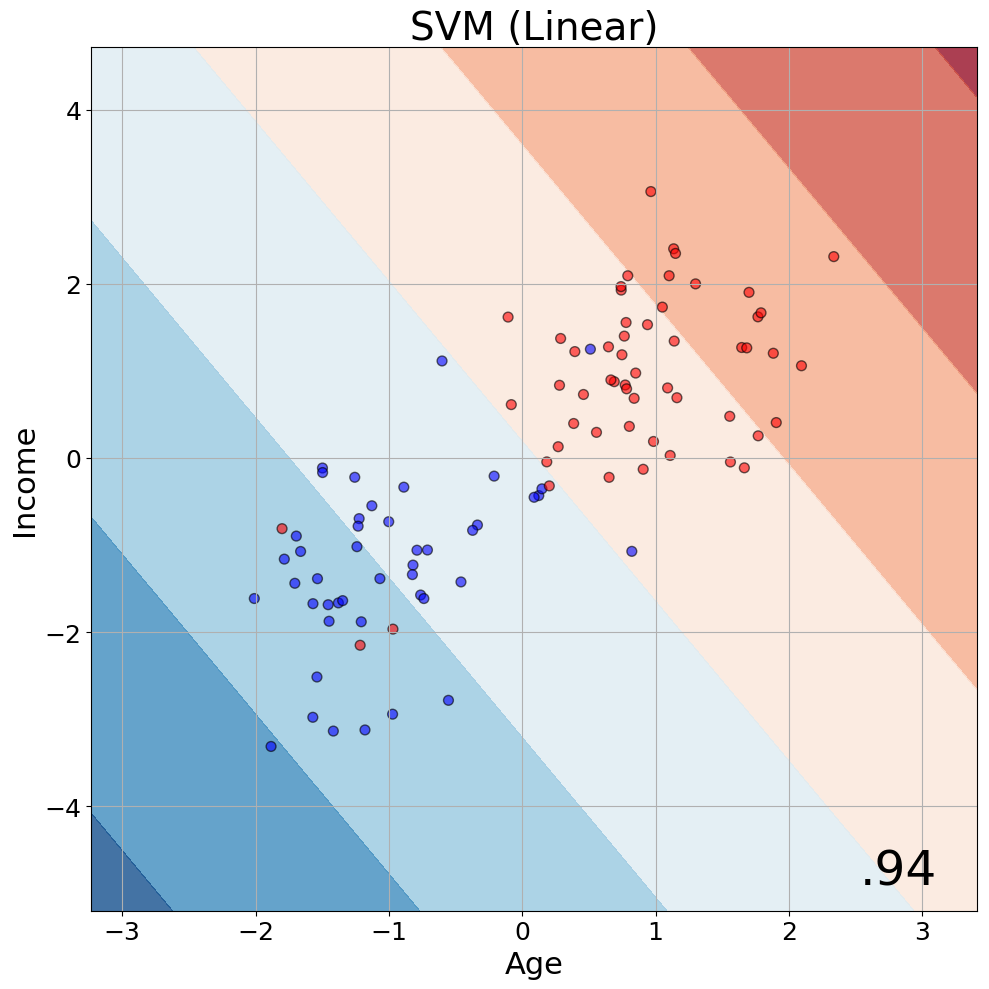

In [137]:
figure = plt.figure(figsize=(10, 10));
ax = plt.subplot(1, 1, 1);
plot_boundaries(X_train, X_test, y_train, y_test, svm_clf, "SVM (Linear)", ax, hide_ticks=False, show_train=False)
ax.set_xlabel("Age", fontsize=22)
ax.set_ylabel("Income", fontsize=22)
plt.tight_layout();
plt.savefig('out/marketing-svm-decision-test.png', transparent=False);

## Experimenting with Different Kernels

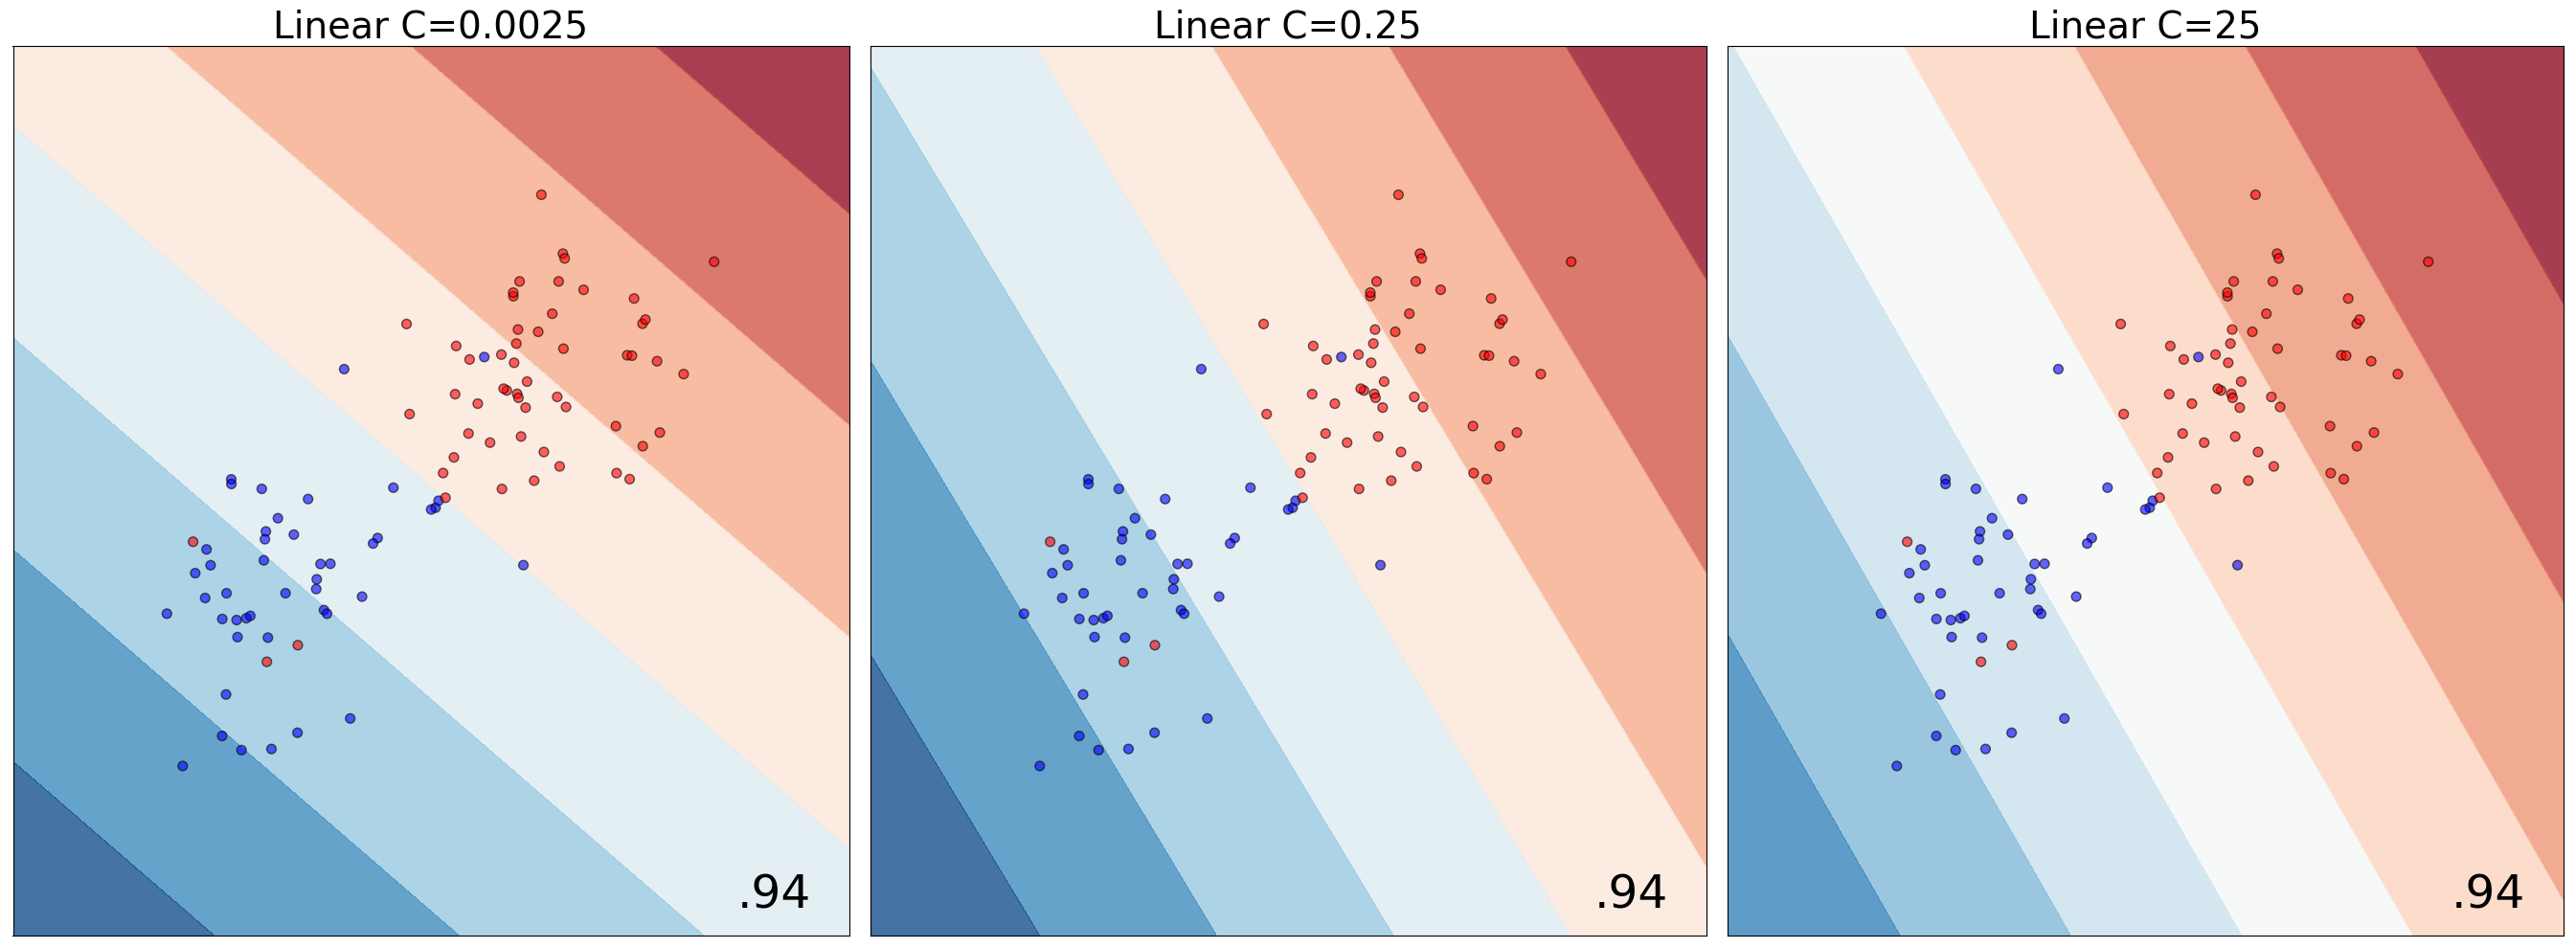

In [138]:
names = ["Linear C=0.0025", "Linear C=0.25", "Linear C=25"]

classifiers = [
    SVC(kernel="linear", C=0.0025),
    SVC(kernel="linear", C=0.25),
    SVC(kernel="linear", C=25),
]

rng = np.random.RandomState(2)

figure = plt.figure(figsize=(27, 10));
i = 1

# iterate over classifiers
for name, clf_tmp in zip(names, classifiers):
    ax = plt.subplot(1, 3, i);
    clf_tmp.fit(X_train, y_train);
    plot_boundaries(X_train, X_test, y_train, y_test, clf_tmp, name, ax, hide_ticks=True, show_train=False);
    i += 1

plt.tight_layout();
plt.savefig('out/marketing-svm-decision-test-all-c.png', transparent=False);

C:\Users\st50\AppData\Local\Continuum\anaconda3\envs\small_sklearn\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\st50\AppData\Local\Continuum\anaconda3\envs\small_sklearn\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\st50\AppData\Local\Continuum\anaconda3\envs\small_sklearn\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this wa

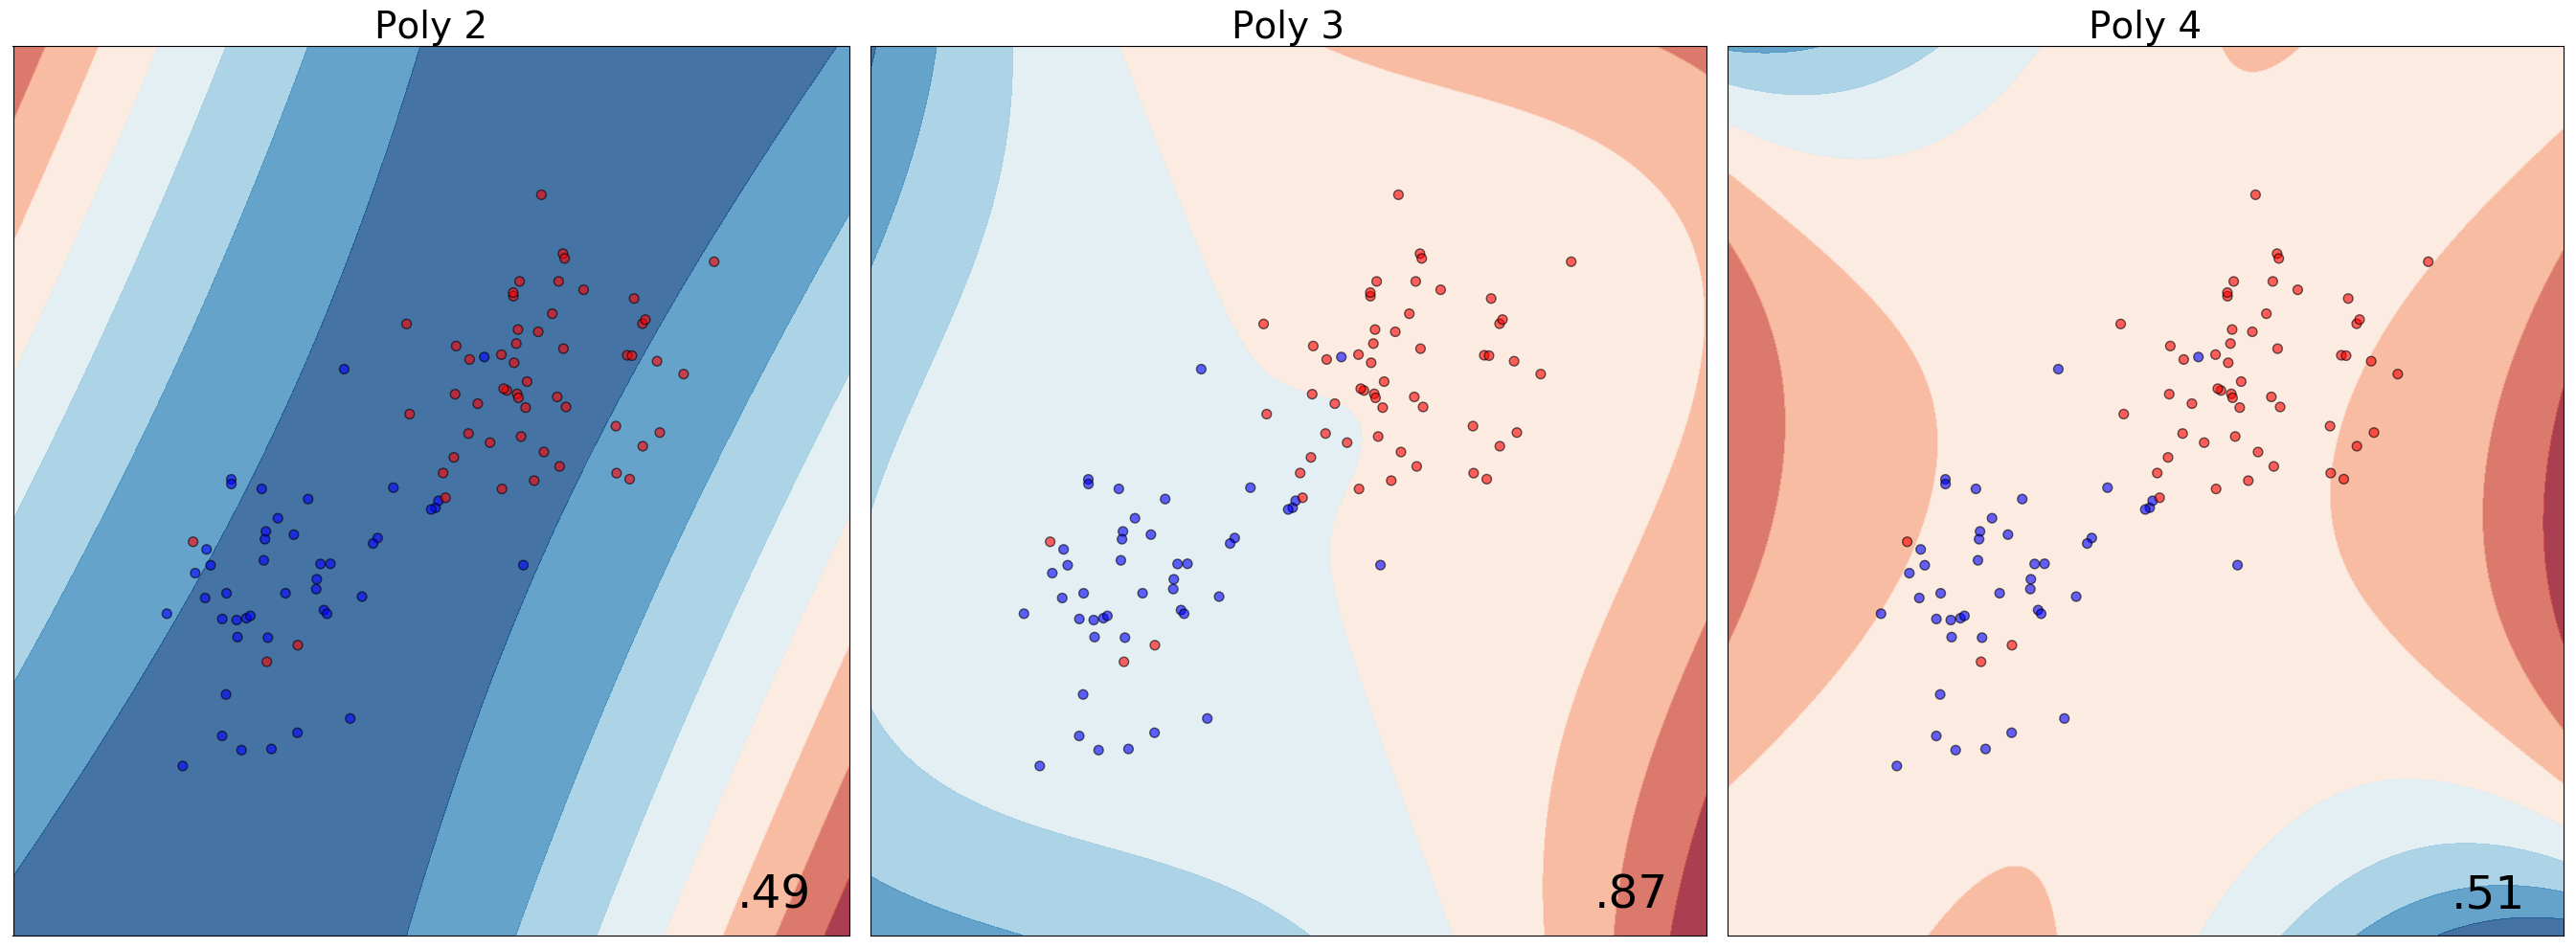

In [139]:
names = ["Poly 2", "Poly 3", "Poly 4"]

classifiers = [
    SVC(kernel="poly", degree=2, C=0.25),
    SVC(kernel="poly", degree=3, C=1),
    SVC(kernel="poly", degree=4, C=1),
]

rng = np.random.RandomState(2)

figure = plt.figure(figsize=(27, 10));
i = 1

# iterate over classifiers
for name, clf_tmp in zip(names, classifiers):
    ax = plt.subplot(1, 3, i);
    clf_tmp.fit(X_train, y_train);
    plot_boundaries(X_train, X_test, y_train, y_test, clf_tmp, name, ax, hide_ticks=True, show_train=False);
    i += 1

plt.tight_layout();
plt.savefig('out/marketing-svm-decision-test-all-poly.png', transparent=False);

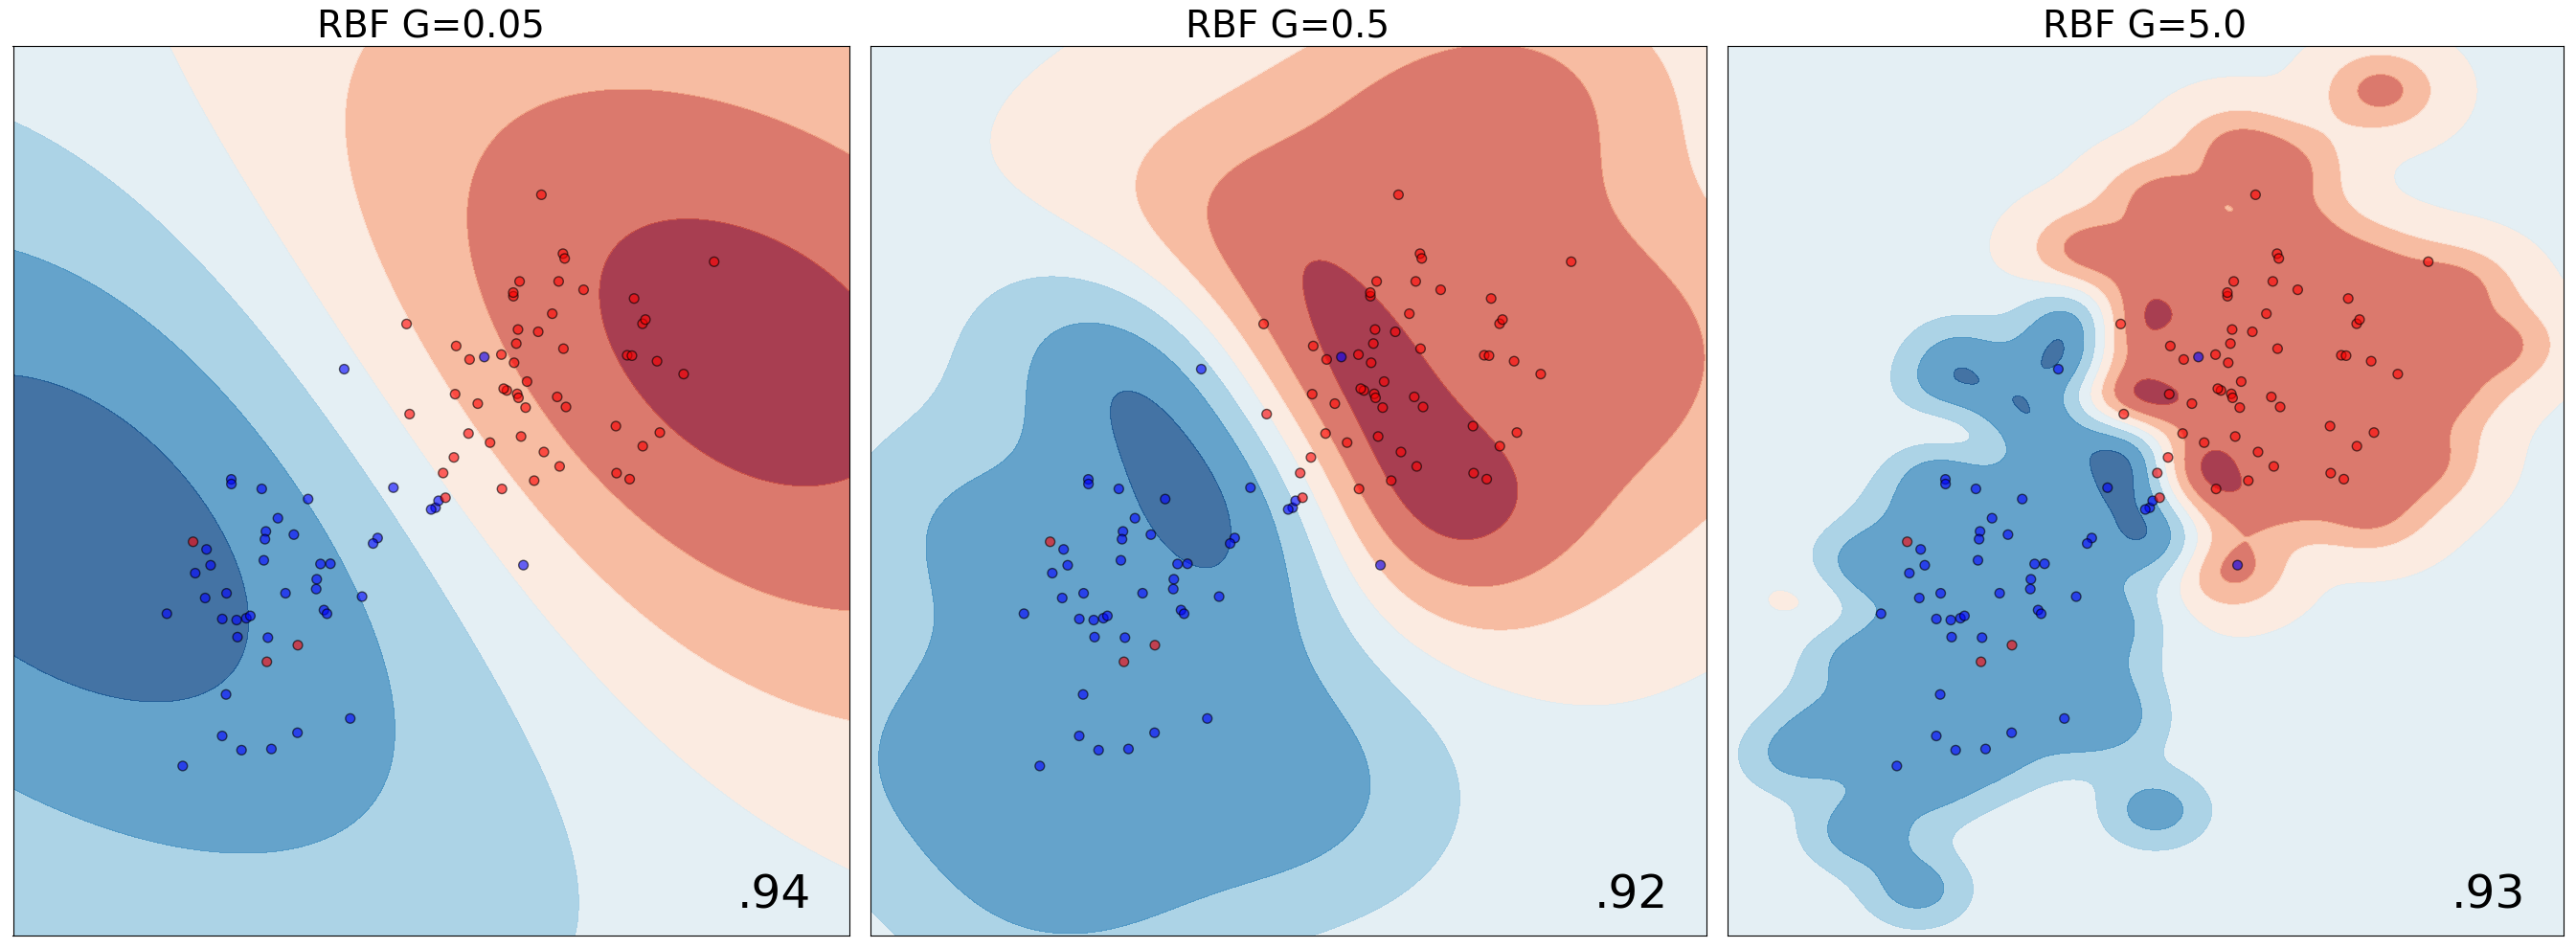

In [140]:
names = ["RBF G=0.05", "RBF G=0.5", "RBF G=5.0"]

classifiers = [
    SVC(kernel="rbf", gamma=0.05, C=1),
    SVC(kernel="rbf", gamma=0.5, C=1),
    SVC(kernel="rbf", gamma=5.0, C=1),
]

rng = np.random.RandomState(2)

figure = plt.figure(figsize=(27, 10));
i = 1

# iterate over classifiers
for name, clf_tmp in zip(names, classifiers):
    ax = plt.subplot(1, 3, i);
    clf_tmp.fit(X_train, y_train);
    plot_boundaries(X_train, X_test, y_train, y_test, clf_tmp, name, ax, hide_ticks=True, show_train=False);
    i += 1

plt.tight_layout();
plt.savefig('out/marketing-svm-decision-test-all-rbf.png', transparent=False);

# NN

In [50]:
from sklearn.neural_network import MLPClassifier

nn_clf = MLPClassifier(solver='lbfgs', activation='relu', alpha=1e-3, 
                       hidden_layer_sizes=(3), random_state=1, verbose=True)
nn_clf.fit(X_train, y_train)

y_pred_nn = nn_clf.predict(X_test)

MLPClassifier(activation='relu', alpha=0.001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=3, learning_rate='constant',
              learning_rate_init=0.001, max_iter=200, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=1, shuffle=True, solver='lbfgs', tol=0.0001,
              validation_fraction=0.1, verbose=True, warm_start=False)

## Model Parameters

In [51]:
nn_clf.loss_

0.27106495217711907

In [52]:
nn_clf.n_layers_

3

In [53]:
w = nn_clf.coefs_ # The ith element in the list represents the weight matrix corresponding to layer i.
w

[array([[ 0.9756526 ,  1.08832583, -1.04406553],
        [-1.66548065, -1.62569205, -0.61746919]]), array([[ 3.91733101],
        [-2.57062869],
        [ 1.76672827]])]

In [54]:
b = nn_clf.intercepts_ # The ith element in the list represents the bias vector corresponding to layer i + 1.
b

[array([-2.08114865, -1.19151499,  1.62527184]), array([-2.59817514])]

In [55]:
nn_clf.out_activation_

'logistic'

In [56]:
nn_clf.predict_proba([[0.5, 1]])

array([[0.85068094, 0.14931906]])

In [57]:
def relu_af(x):
    return max(0, x)
    
x = [0.5, 1]

layer_id=0
h0 = (x[0] * w[layer_id][0][0]) + ((x[1] * w[layer_id][1][0])) + (1 * b[layer_id][0])
print(h0)
print(relu_af(h0))

h1 = (x[0] * w[layer_id][0][1]) + ((x[1] * w[layer_id][1][1])) + (1 * b[layer_id][1])
print(h1)
print(relu_af(h1))

h2 = (x[0] * w[layer_id][0][2]) + ((x[1] * w[layer_id][1][2])) + (1 * b[layer_id][2])
print(h2)
print(relu_af(h2))

layer_id=1
o = (h0 * w[layer_id][0][0]) + ((h1 * w[layer_id][1][0])) + ((h2 * w[layer_id][2][0])) + (1 * b[layer_id][0])
print(o)
print(relu_af(o))

-3.2588029971077006
0
-2.2730441233420393
0
0.48576987738849486
0.48576987738849486
-8.662609371944365
0


## Model Performance

In [58]:
print(confusion_matrix(y_test, y_pred_nn))

[[51  4]
 [ 2 43]]


In [59]:
print(classification_report(y_test, y_pred_nn, target_names=class_names))

              precision    recall  f1-score   support

           0       0.96      0.93      0.94        55
           1       0.91      0.96      0.93        45

    accuracy                           0.94       100
   macro avg       0.94      0.94      0.94       100
weighted avg       0.94      0.94      0.94       100



In [60]:
print("Accuracy = {:.2f}".format(accuracy_score(y_test, y_pred_nn)))
print("Kappa = {:.2f}".format(cohen_kappa_score(y_test, y_pred_nn)))
print("F1 Score = {:.2f}".format(f1_score(y_test, y_pred_nn)))
print("Log Loss = {:.2f}".format(log_loss(y_test, y_pred_nn)))

Accuracy = 0.94
Kappa = 0.88
F1 Score = 0.93
Log Loss = 2.07


## Model Visualization

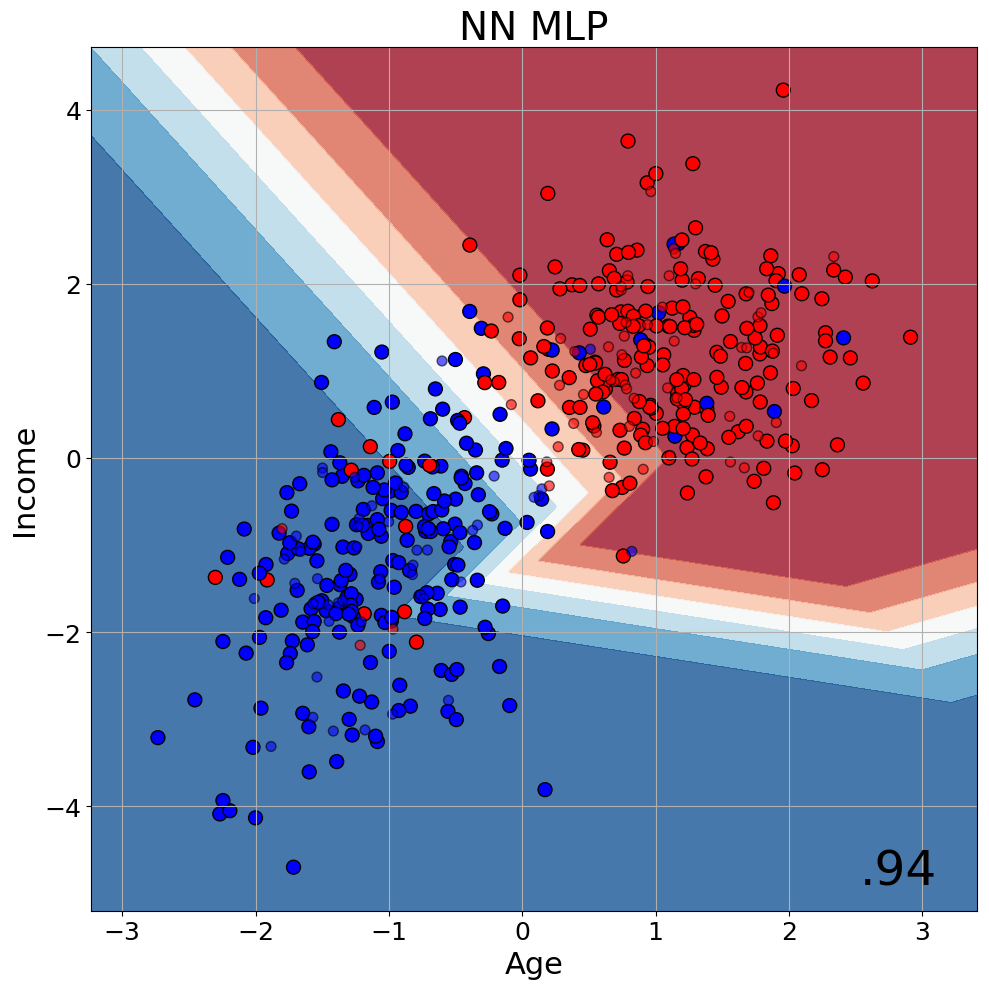

In [61]:
figure = plt.figure(figsize=(10, 10));
ax = plt.subplot(1, 1, 1);
plot_boundaries(X_train, X_test, y_train, y_test, nn_clf, "NN MLP", ax, hide_ticks=False, show_train=False)
ax.set_xlabel("Age", fontsize=22)
ax.set_ylabel("Income", fontsize=22)
plt.tight_layout();
plt.savefig('out/marketing-nn-decision-test.png', transparent=False);

## Experimenting with Mulitple Activation Functions

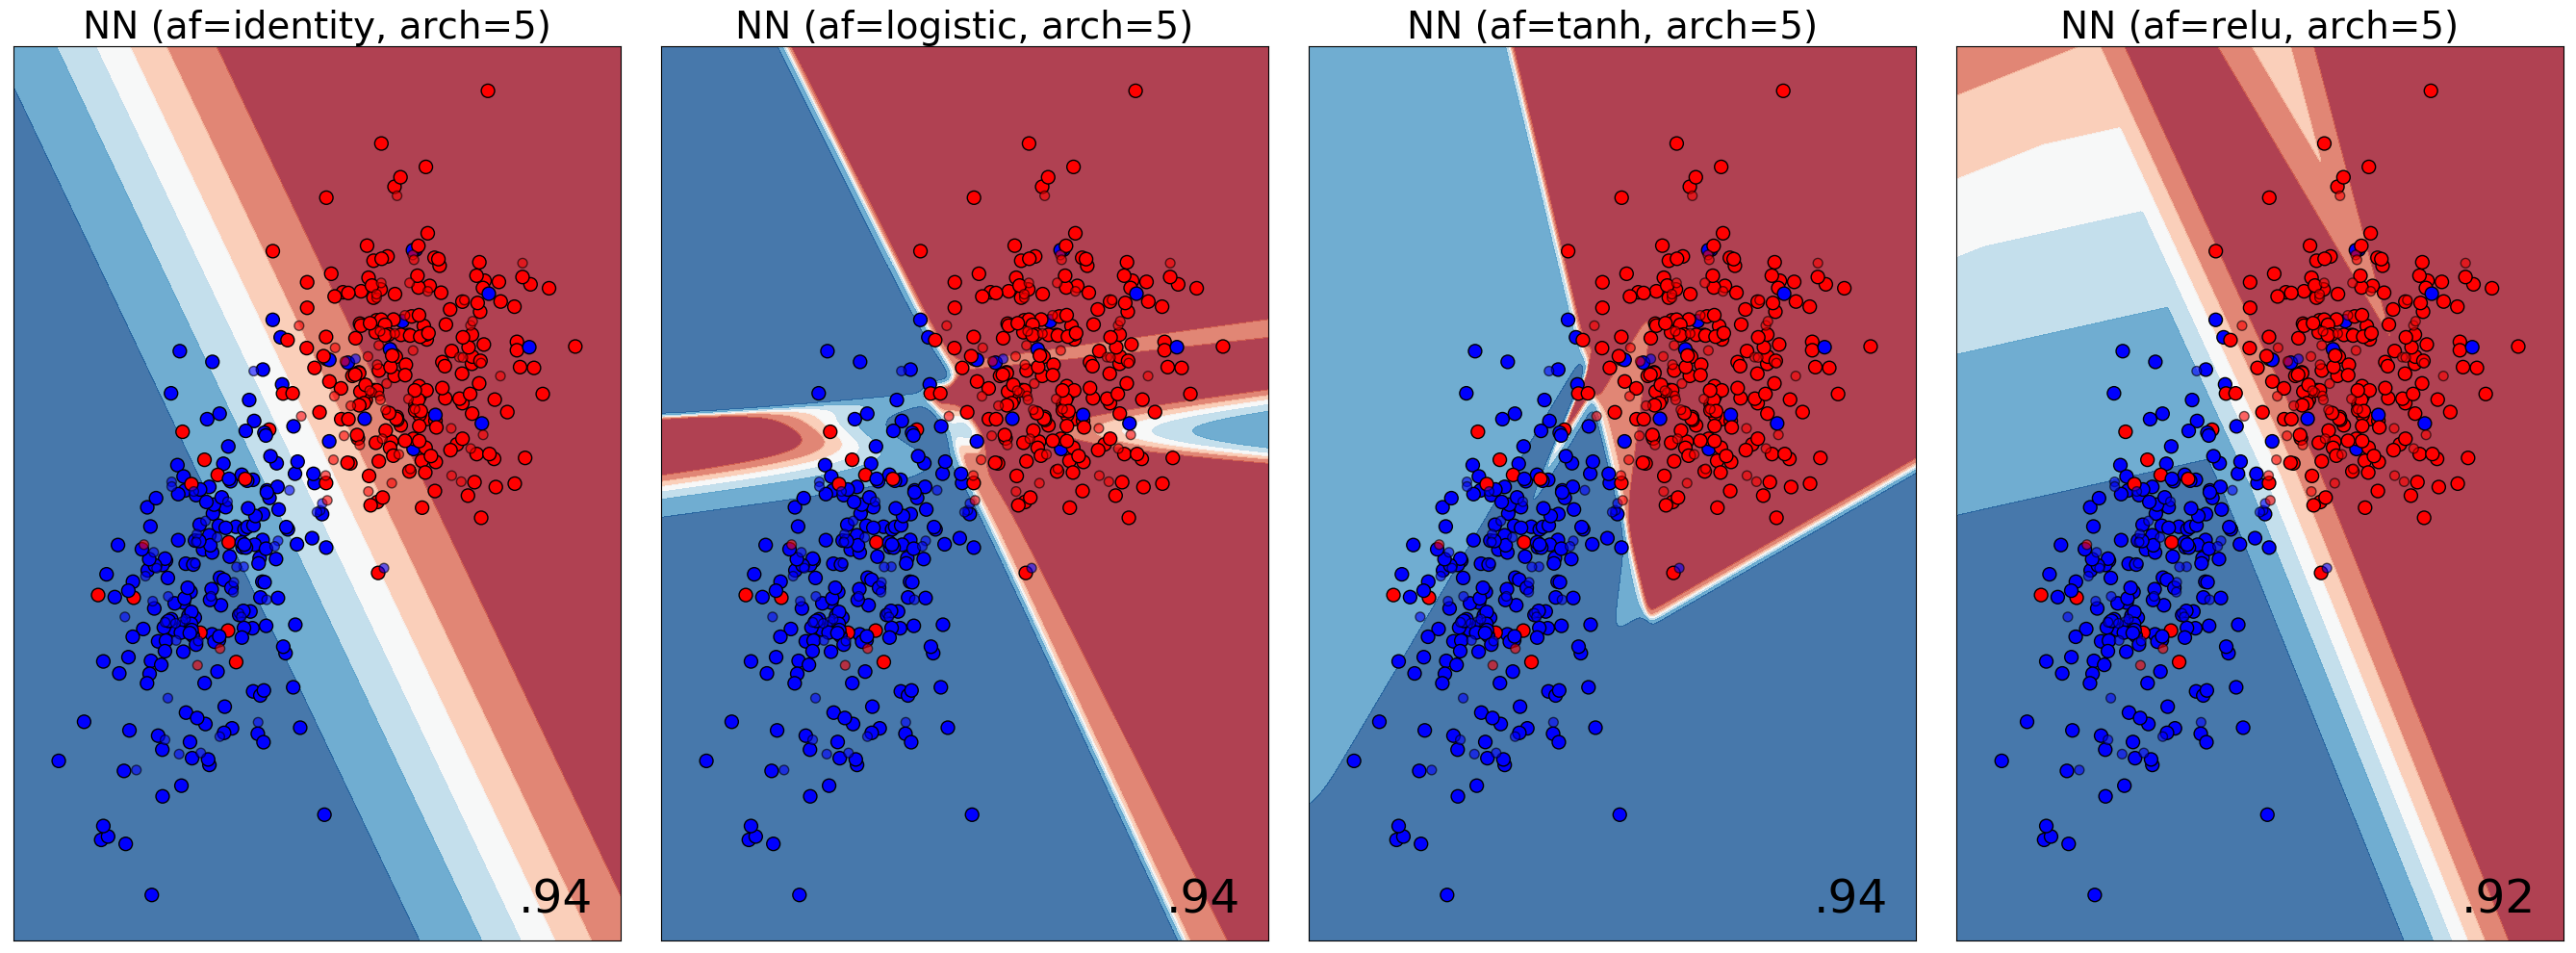

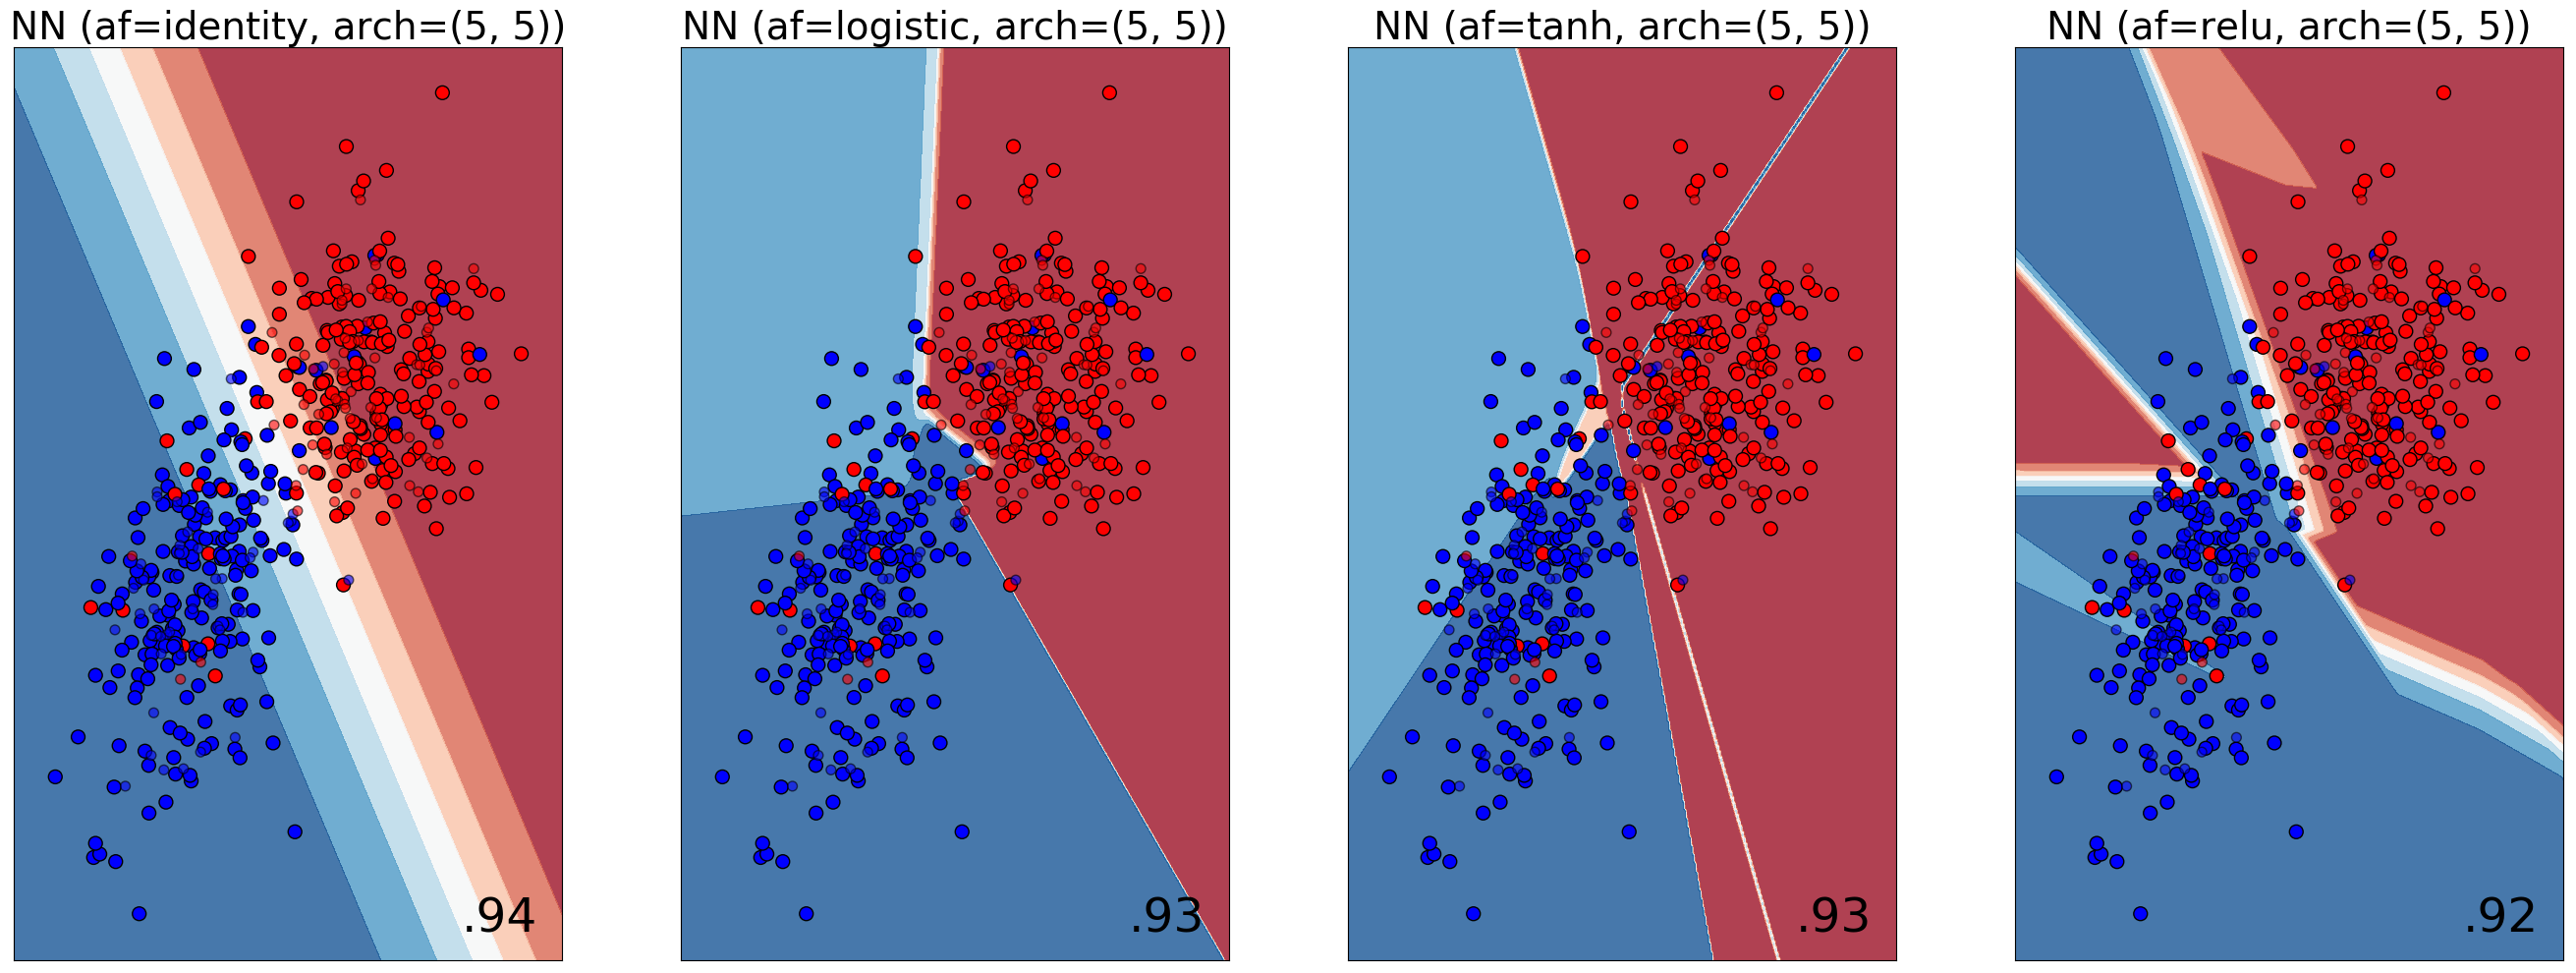

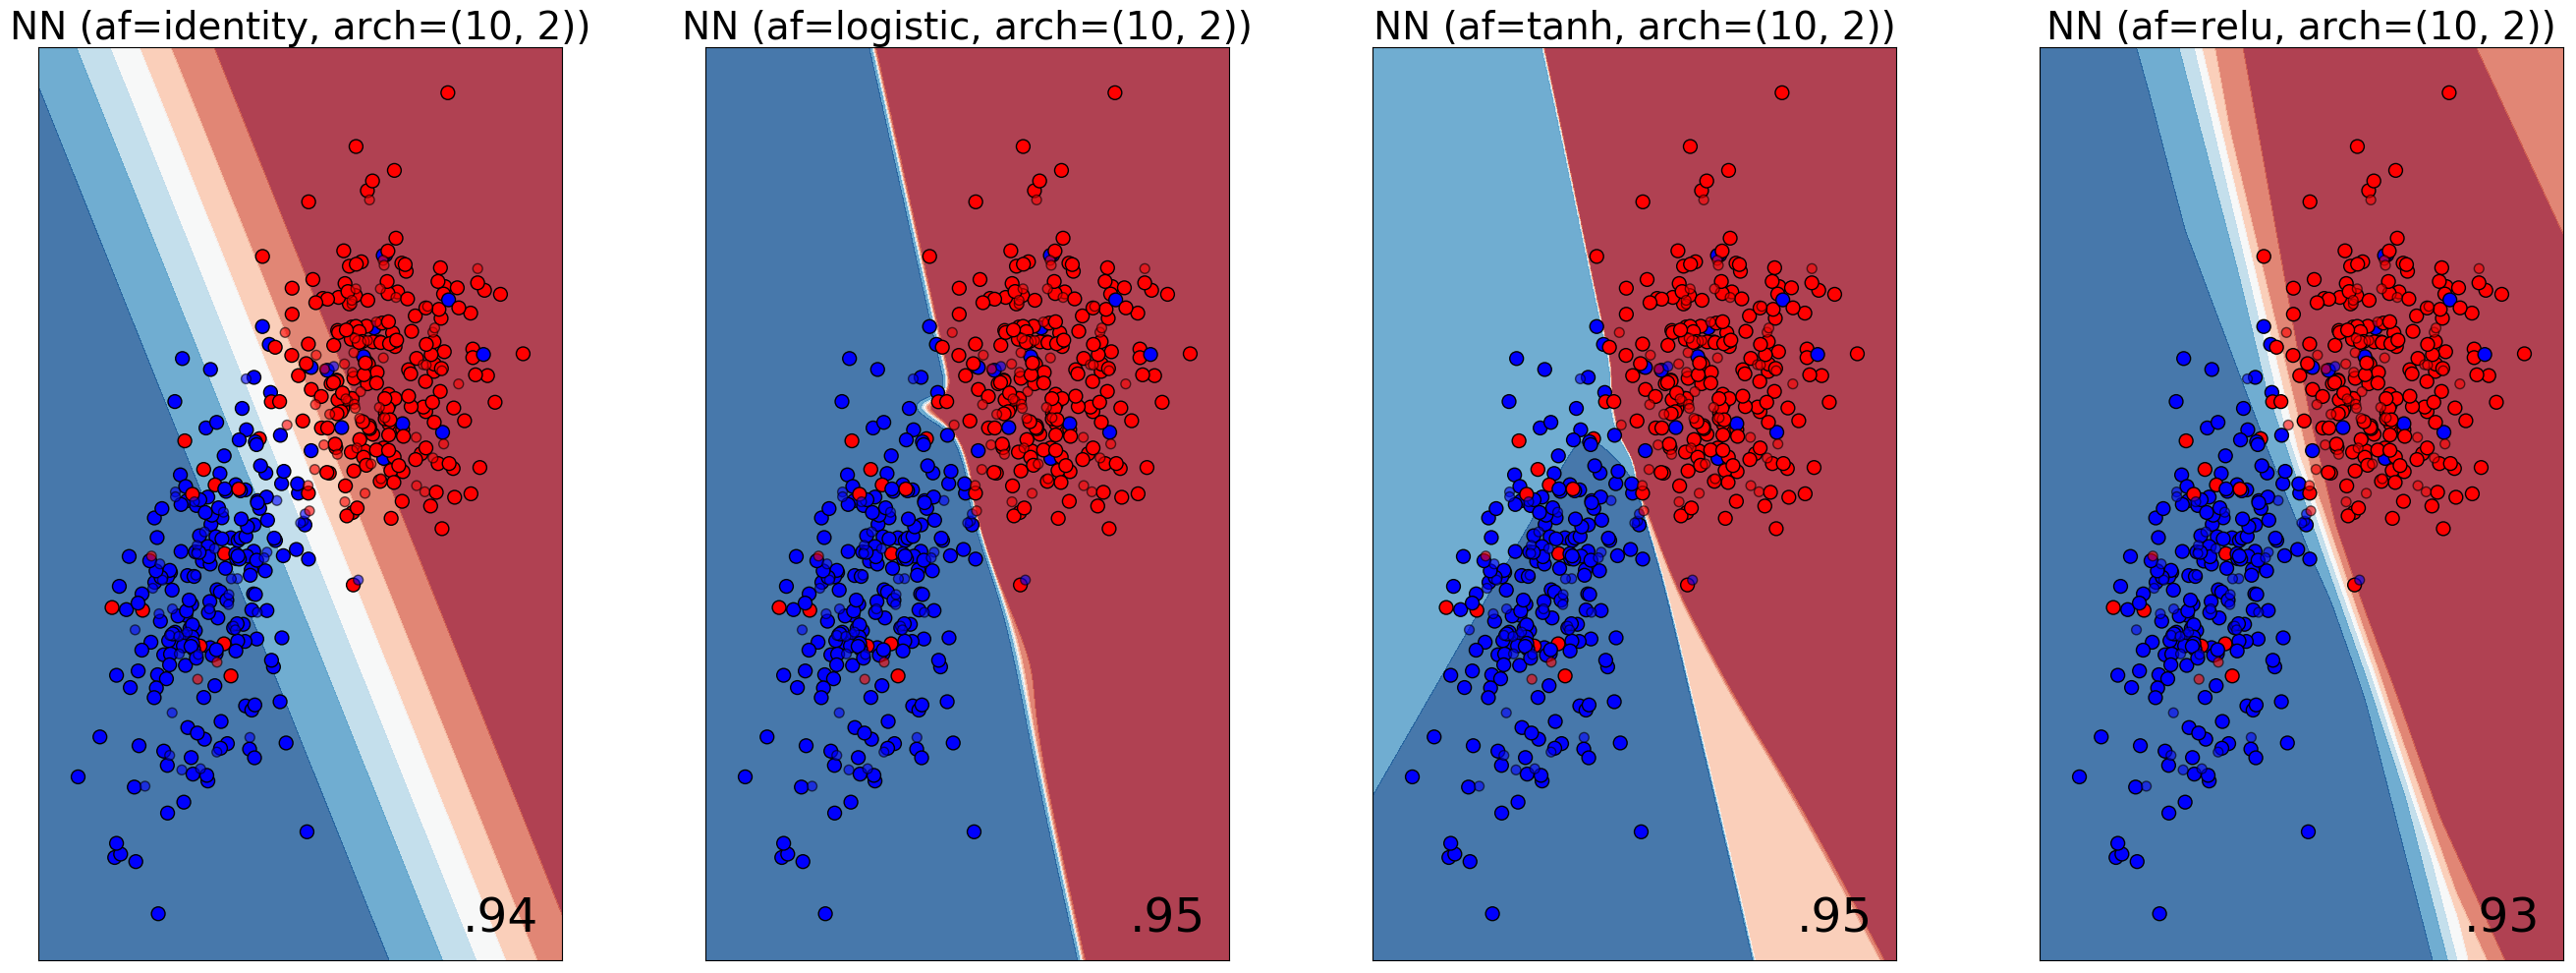

In [62]:
rng = np.random.RandomState(2)

alpha=0.001
archs = [(5), (5, 5), (10, 2)]
afs = ['identity', 'logistic', 'tanh', 'relu']

j = 1

for arch in archs:
    figure = plt.figure(figsize=(27, 10));
    i = 1
    
    for af in afs:
        ax = plt.subplot(1, 4, i);
        clf_tmp = MLPClassifier(solver='lbfgs', activation=af, alpha=alpha, hidden_layer_sizes=arch, random_state=1);
        clf_tmp = clf_tmp.fit(X_train, y_train);
        plot_boundaries(X_train, X_test, y_train, y_test, clf_tmp, "NN (af={}, arch={})".format(af, arch, alpha), ax, hide_ticks=True);
        i += 1
        
    plt.tight_layout();
    j += 1


## Experimenting with Mulitple Alphas

[1.e-01 1.e-02 1.e-03 1.e-04 1.e-05 1.e-06 1.e-07 1.e-08 1.e-09 1.e-10
 1.e-11]


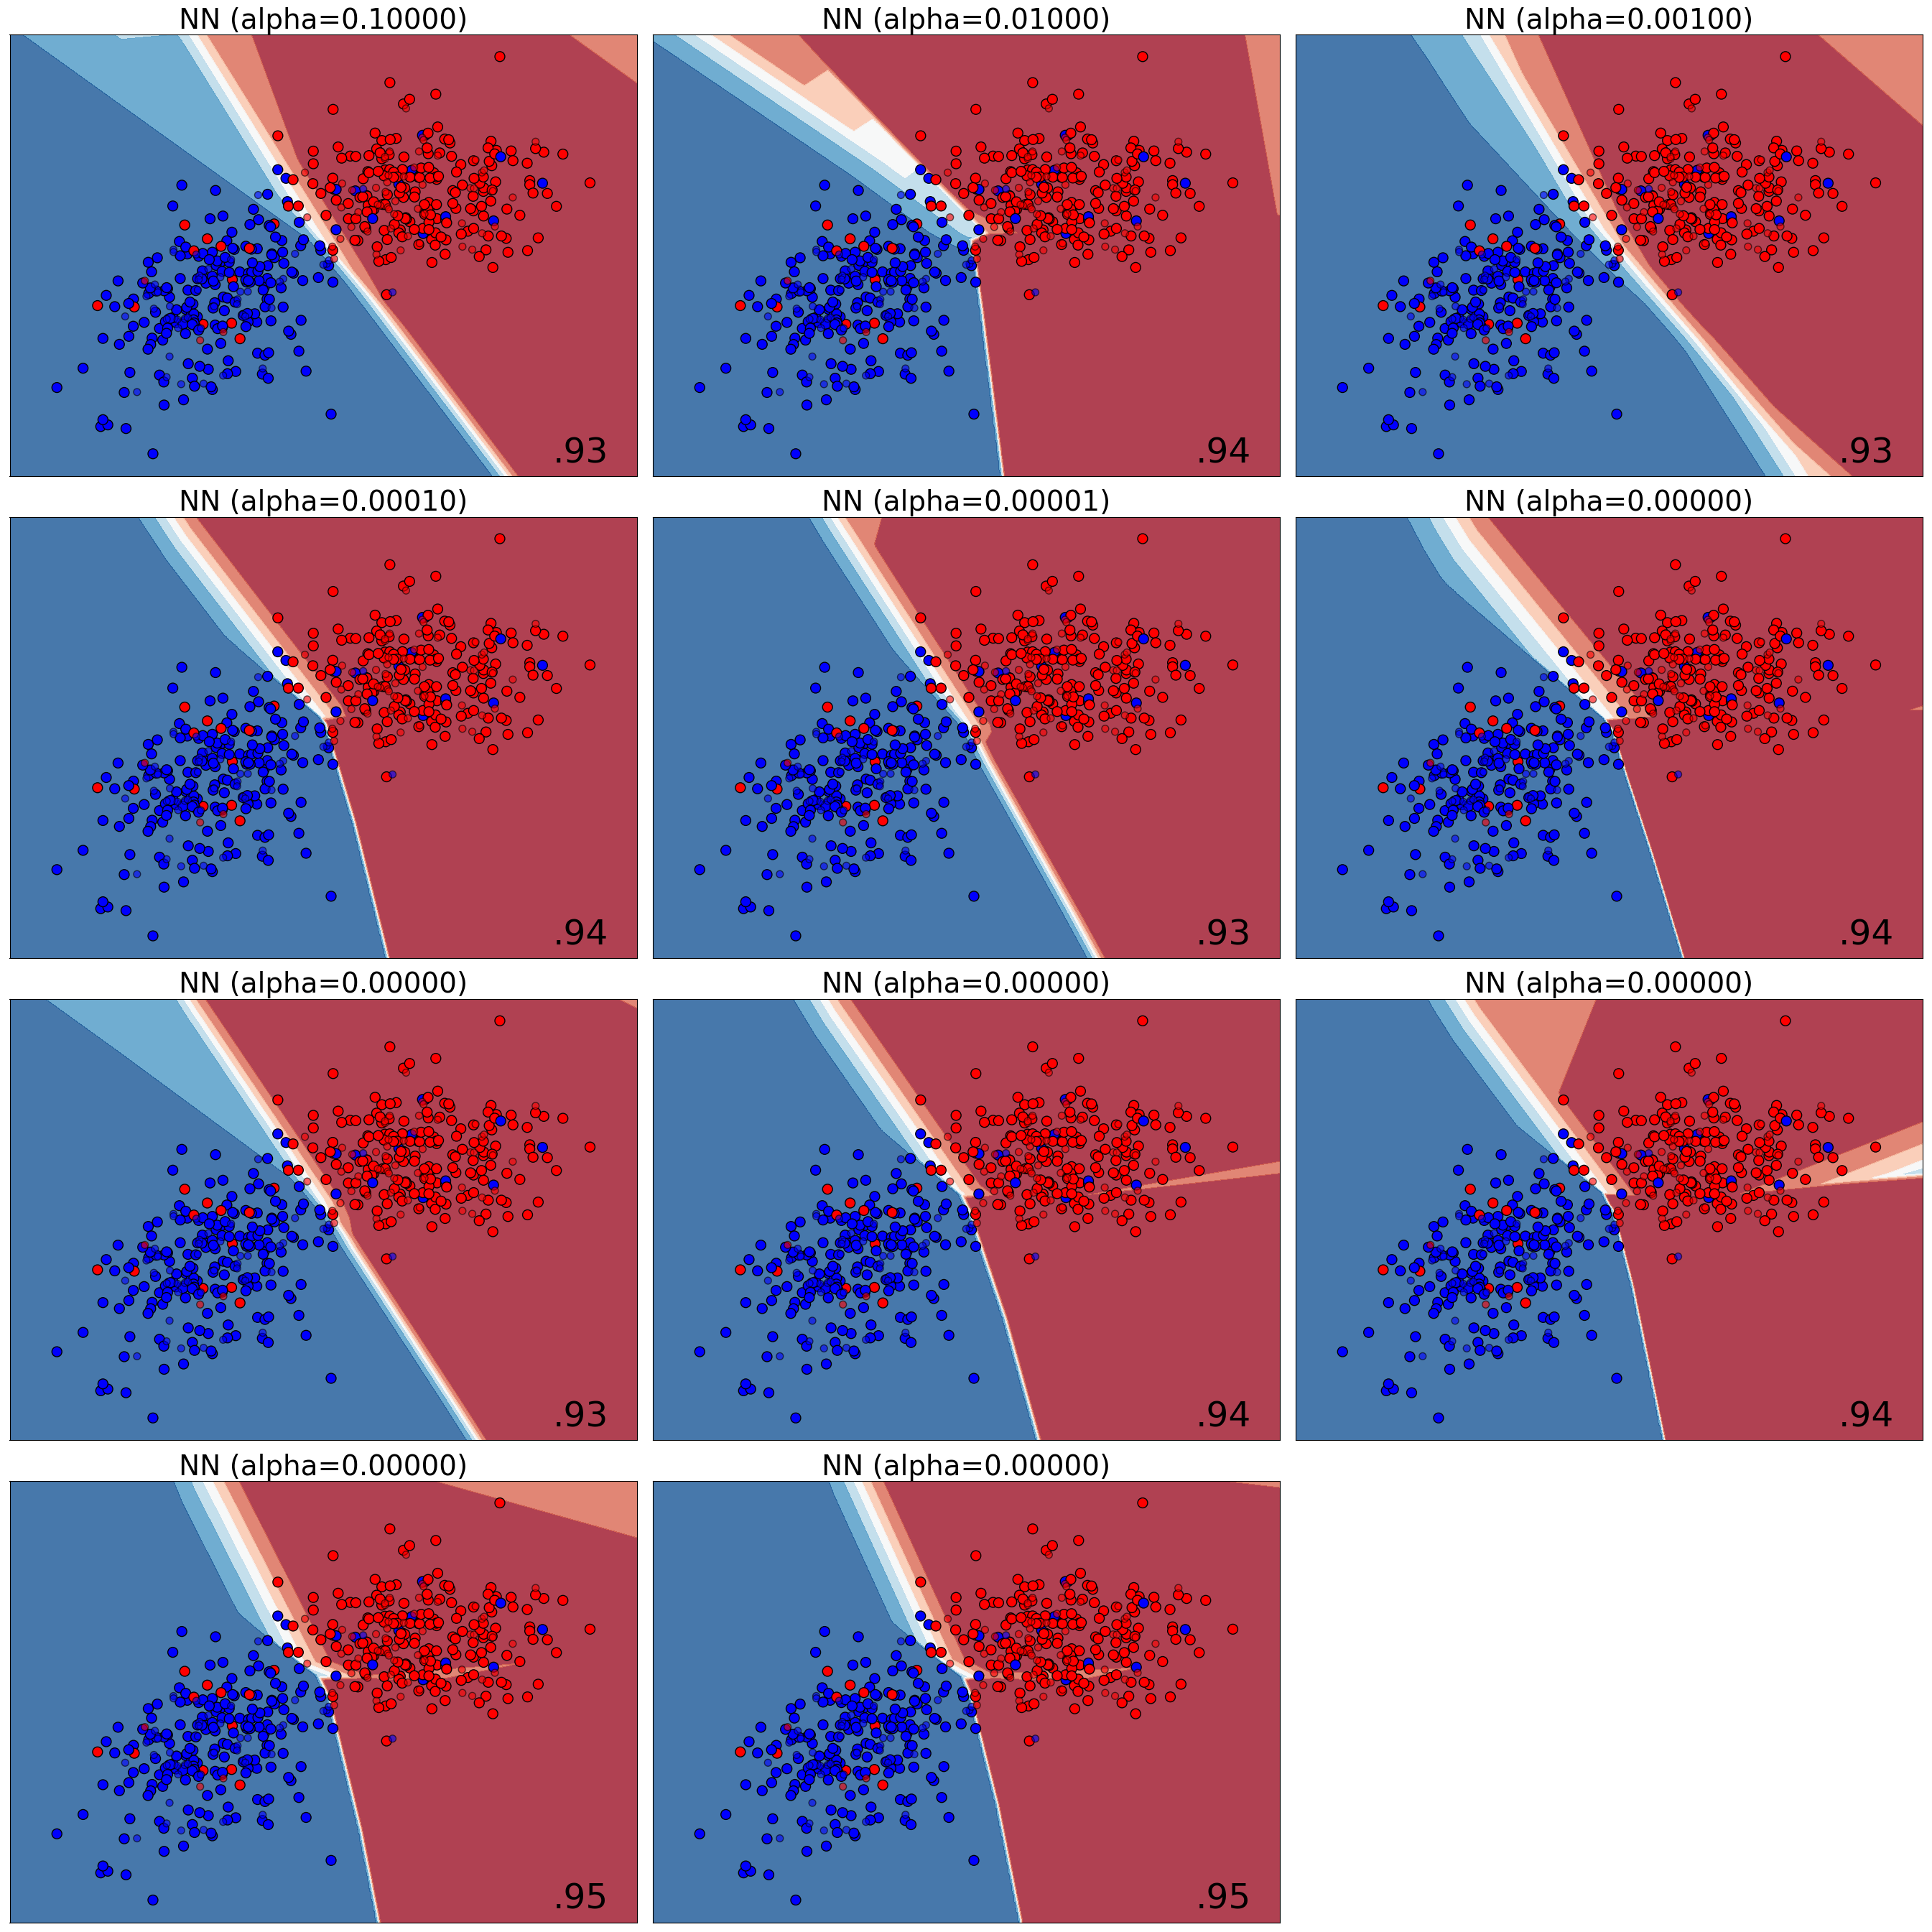

In [63]:
rng = np.random.RandomState(2)

figure = plt.figure(figsize=(27, 27));
i = 1

alphas = 10.0 ** -np.arange(1, 12)
print(alphas)

for alpha in alphas:
    ax = plt.subplot(4, 3, i);
    clf_tmp = MLPClassifier(solver='lbfgs', activation='relu', alpha=alpha, hidden_layer_sizes=(10, 2), random_state=1)
    clf_tmp.fit(X_train, y_train);
    plot_boundaries(X_train, X_test, y_train, y_test, clf_tmp, "NN (alpha={:.5f})".format(alpha), ax, hide_ticks=True);
    i += 1

plt.tight_layout();

# Comparing Multiple Algorithms

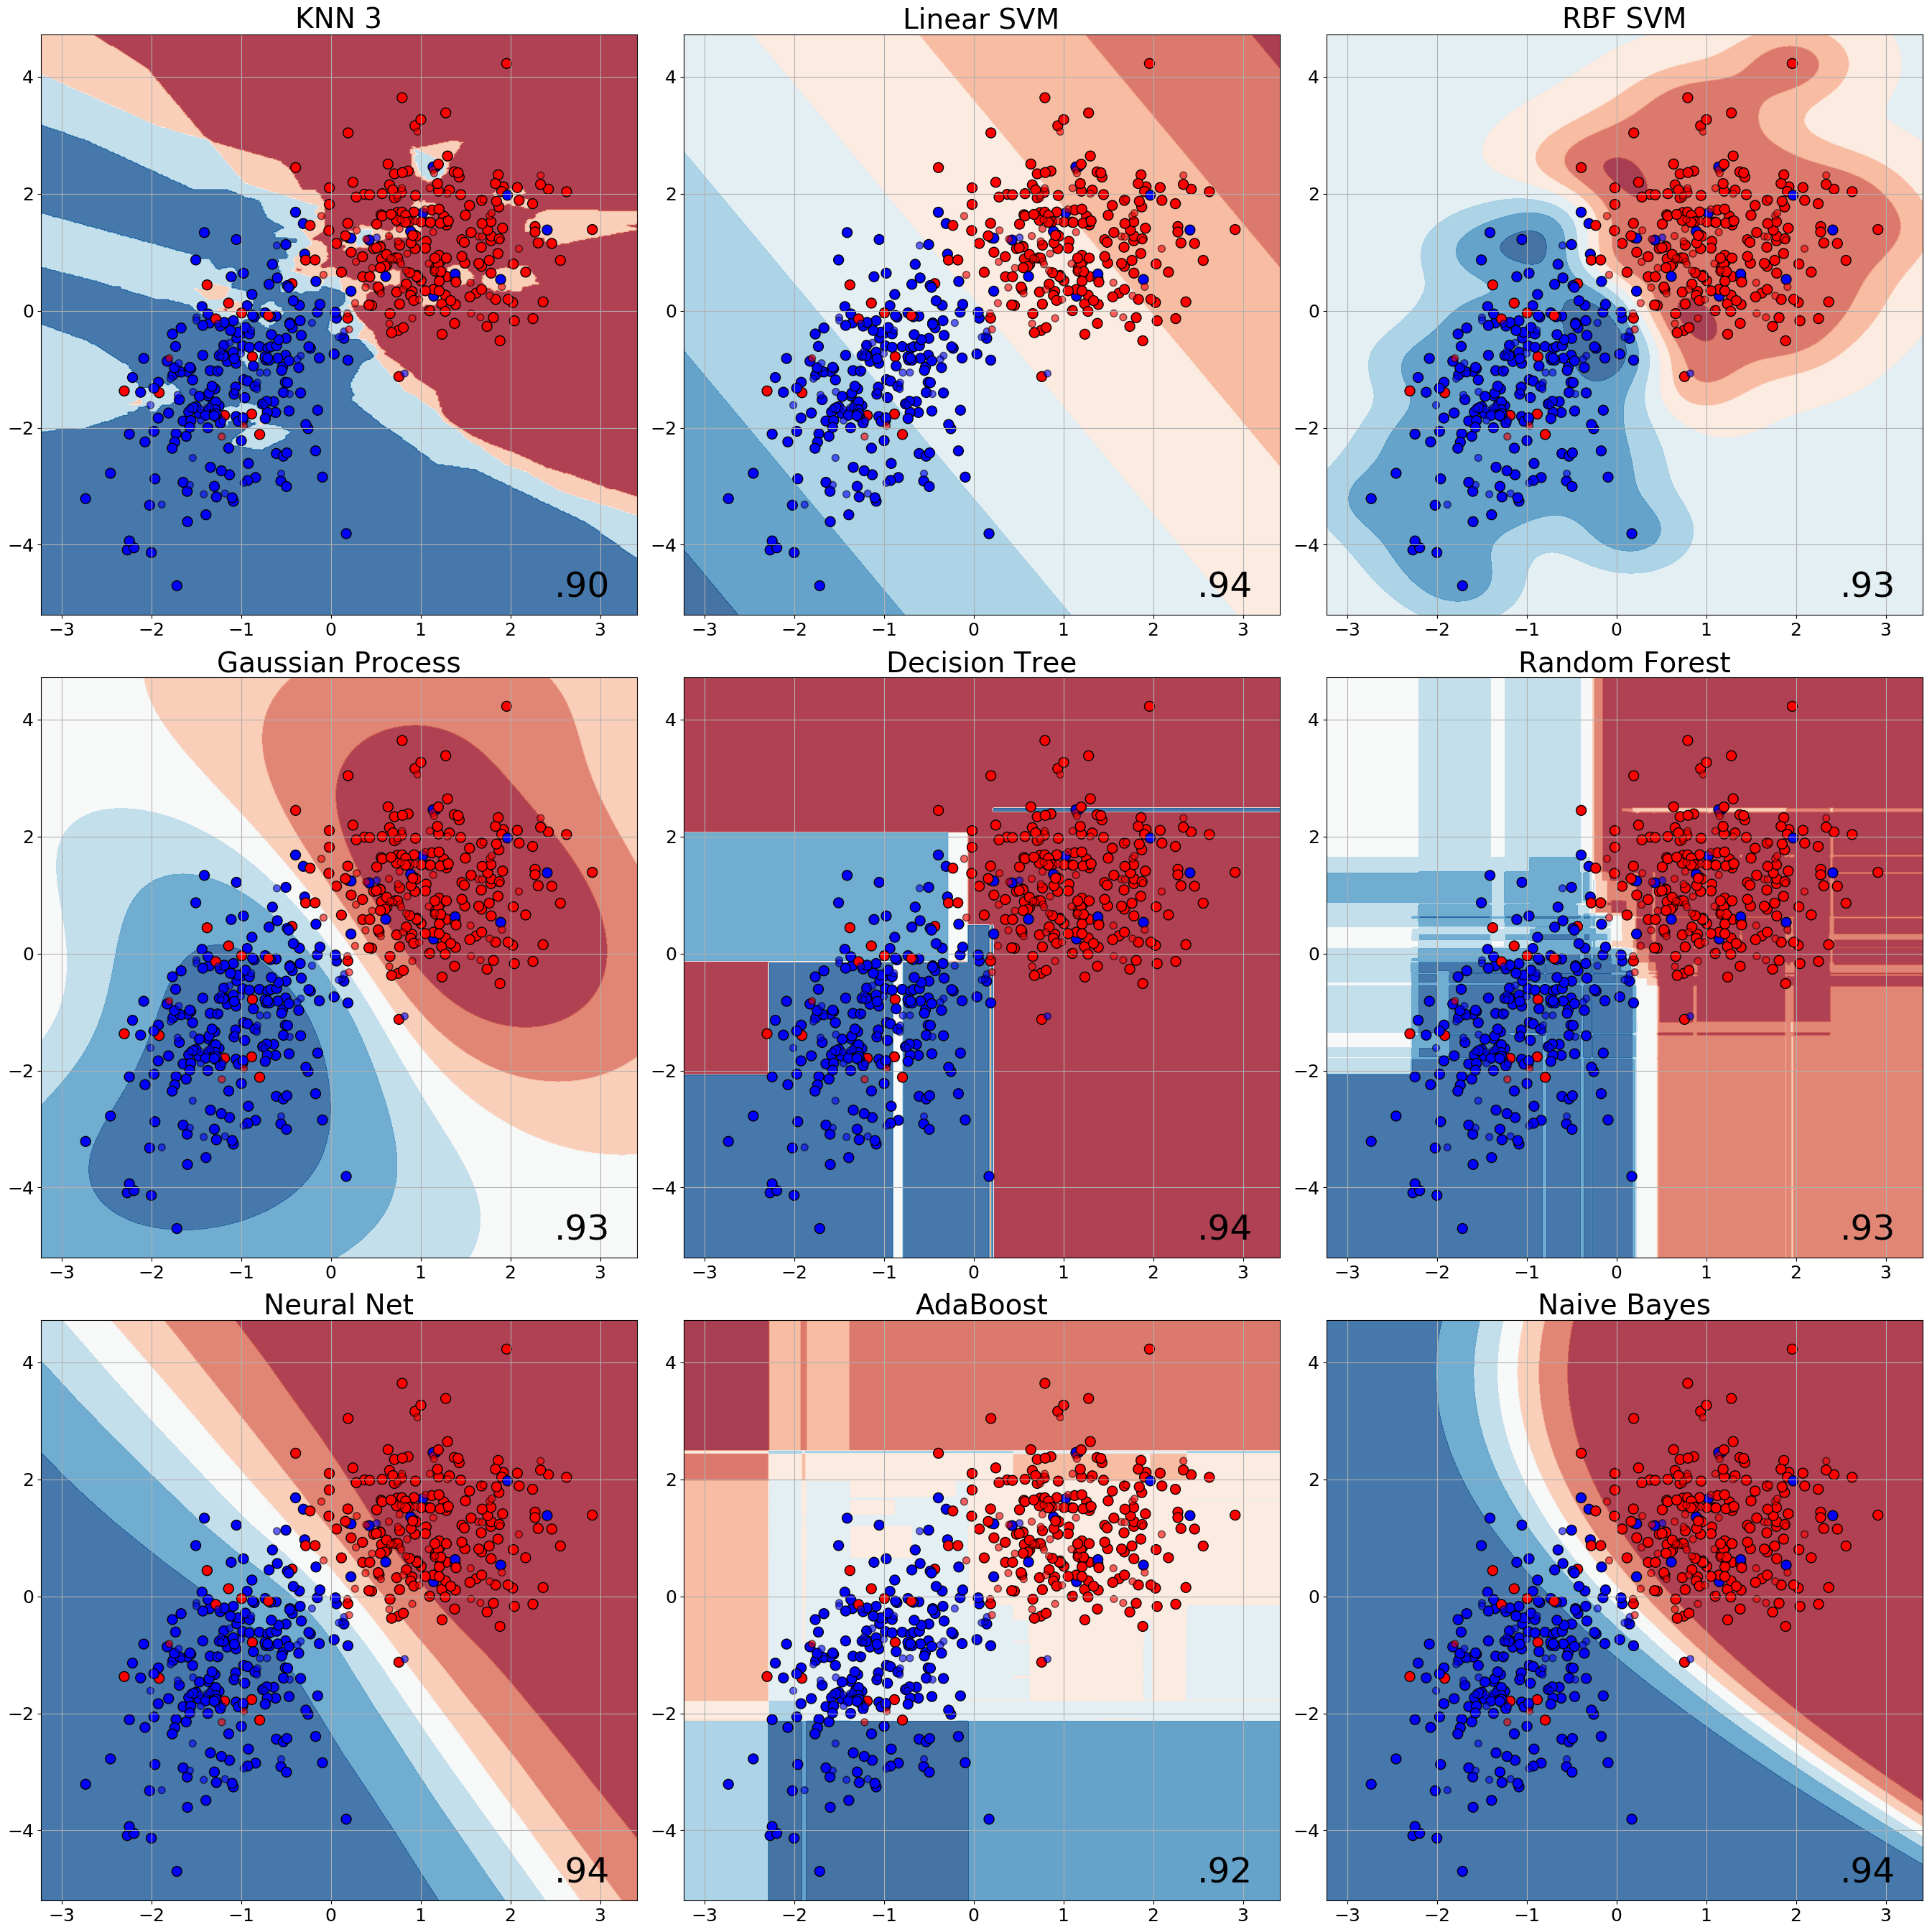

In [64]:
# Inspired by: https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis


names = ["KNN 3", "Linear SVM", "RBF SVM", "Gaussian Process",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes"]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1),
    AdaBoostClassifier(),
    GaussianNB()]


rng = np.random.RandomState(2)

figure = plt.figure(figsize=(27, 27));
i = 1

# iterate over classifiers
for name, clf_tmp in zip(names, classifiers):
    ax = plt.subplot(3, 3, i);
    clf_tmp.fit(X_train, y_train);
    plot_boundaries(X_train, X_test, y_train, y_test, clf_tmp, name, ax, hide_ticks=False, show_train=False);
    i += 1

plt.tight_layout();
plt.savefig('out/marketing-all-decision.png', transparent=False);

# KCU Data

In [157]:
#kcu_df = pd.read_csv("https://raw.githubusercontent.com/stepthom/sandbox/master/data/KCU.csv")
kcu_df = pd.read_csv("data/KCU.csv")

kcu_df = kcu_df.drop(['age'], axis=1)

list(kcu_df)
kcu_df.shape
kcu_df.info()
kcu_df.describe().transpose()
kcu_df.head(n=20)

['has_job', 'own_house', 'credit_rating', 'paid_back']

(15, 4)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15 entries, 0 to 14
Data columns (total 4 columns):
has_job          15 non-null bool
own_house        15 non-null bool
credit_rating    15 non-null object
paid_back        15 non-null object
dtypes: bool(2), object(2)
memory usage: 350.0+ bytes


count unique    top freq
has_job          15      2  False   10
own_house        15      2  False    9
credit_rating    15      3   good    6
paid_back        15      2    yes    9

has_job  own_house credit_rating paid_back
0     False      False          fair        no
1     False      False          good        no
2     False      False          fair        no
3      True      False          good       yes
4     False      False          fair        no
5      True      False          good       yes
6      True      False     excellent       yes
7     False      False          fair        no
8     False      False          good        no
9      True       True          fair       yes
10    False       True     excellent       yes
11    False       True          good       yes
12    False       True     excellent       yes
13    False       True     excellent       yes
14     True       True          good       yes

In [158]:
from sklearn.preprocessing import OneHotEncoder


kcu_df = pd.concat([kcu_df, pd.get_dummies(kcu_df['credit_rating'], prefix="credit_rating")],axis=1)
kcu_df = kcu_df.drop(['credit_rating'], axis = 1)
kcu_df.head()

has_job  own_house paid_back  credit_rating_excellent  credit_rating_fair  \
0    False      False        no                        0                   1   
1    False      False        no                        0                   0   
2    False      False        no                        0                   1   
3     True      False       yes                        0                   0   
4    False      False        no                        0                   1   

   credit_rating_good  
0                   0  
1                   1  
2                   0  
3                   1  
4                   0

In [159]:
y_kcu = kcu_df[['paid_back']]
X_kcu = kcu_df.drop('paid_back', axis=1)

## Decision Tree

In [167]:
from sklearn.tree import DecisionTreeClassifier

clf_kcu = DecisionTreeClassifier(random_state=42, criterion="entropy", max_depth=3, max_leaf_nodes=5)
clf_kcu.fit(X_kcu, y_kcu)

feature_names_kcu = X_kcu.columns
class_names_kcu = [str(x) for x in clf_kcu.classes_]

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=3,
                       max_features=None, max_leaf_nodes=5,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=42, splitter='best')

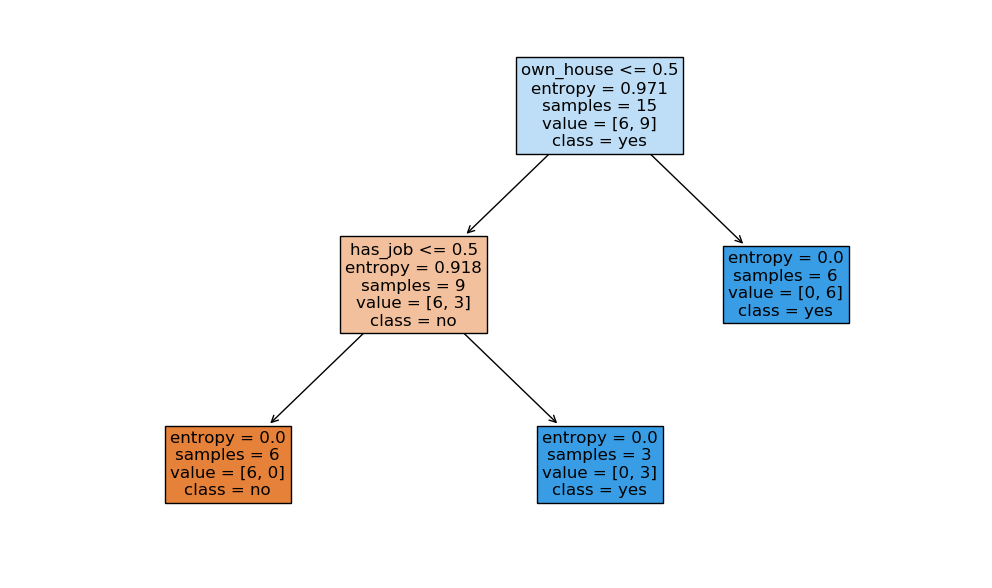

In [168]:
# Needs sklearn 0.21 or higher
from sklearn.tree import plot_tree

plt.figure(figsize=(12, 7));
plot_tree(clf_kcu, filled=True, feature_names=feature_names_kcu, class_names=class_names_kcu, proportion=False, fontsize=12);
plt.savefig('out/kcu-dt-tree.png', transparent=False);